# 국민청원 데이터 분석하기
* 이 노트북의 경로 : 
# https://goo.gl/Hp8jVa
* 국민청원은 2017년 8월에 처음시작되어 이제 1년 반 정도(현재시점 2019년 2월)가 되었습니다. 
* 해당 내용을 통해 사회적 이슈를 분석하거나 확인해 볼 수도 있지만,
* 이 튜토리얼은 청와대 국민청원 데이터를 통해 텍스트 데이터 분석에 입문하고 간단한 머신러닝을 활용해 보는 것에 목적을 두고 있습니다.
* 만료된 청원을 분석합니다
* 로컬 주피터 노트북에서 실습하고자 하시는 분들은 아래의 소스코드를 활용해 주세요.
* github  :  https://github.com/corazzon/petitionWrangling/blob/master/02-pandas-plotnine.ipynb

In [0]:
# 출력데이터가 지저분하게 보이지 않도록
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install plotnine==0.5.0
!pip install --upgrade pandas==0.23.4

    100% |████████████████████████████████| 3.6MB 10.1MB/s 
    100% |████████████████████████████████| 10.1MB 936kB/s 
    100% |████████████████████████████████| 61kB 25.7MB/s 
    100% |████████████████████████████████| 81kB 29.5MB/s 
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


    100% |████████████████████████████████| 8.9MB 4.3MB/s 
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1


In [3]:
import pandas as pd
from pandas.api.types import CategoricalDtype # 그래프의 값을 정렬해서 보기위해
import numpy as np

print(pd.__version__)
print(np.__version__)

0.22.0
1.14.6


여기에서는 시각화 도구로 [plotnine(A grammar of graphics for Python)](https://github.com/has2k1/plotnine)을 사용한다.

In [0]:
from plotnine import *

# Pandas로 데이터 살펴보기
* 데이터 출처 : https://github.com/akngs/petitions

In [5]:
# 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증을 합니다.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 22.0MB/s 


In [6]:
url ='https://drive.google.com/open?id=1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4'
id = url.split('=')[1]
print(id)

1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4


In [7]:
%ls

adc.json  sample_data/


In [0]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어온다.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('petition.csv')  

In [9]:
petitions = pd.read_csv('petition.csv', index_col=0, \
                        parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 본다.
petitions.shape

(377756, 7)

## 일부 데이터 미리보기
* 전체 데이터를 한꺼번에 읽어오면 스크롤도 길고 내용이 너무 많기 때문에 일부 데이터만을 본다.
* head()는 윗부분의 데이터 5개를 기본값으로 읽어오고 tail()은 마지막 부분의 데이터를 읽어온다.
* 터미널에서 파일을 미리보기 할 때 사용하는 명령어와 같다.

In [10]:
# head를 통해 상위 몇 개의 데이터만을 본다.
# 기본은 5개를 불러오며, 괄호안에 숫자를 적어주면 숫자만큼 불러온다.
petitions.head(3)

,start,end,answered,votes,category,title,content
article_id,,,,,,,
21,2017-08-19,2017-11-17,0,9,안전/환경,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...
22,2017-08-19,2017-11-17,0,17,기타,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...
23,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."


In [11]:
# 위에서 불러온 head와 반대로 뒤에서부터 데이터를 읽어온다.
# 터미널에서 크롤링을 하며 tail 파일명으로 크롤링 데이터를 읽었던 기억을 떠올려 보자.
petitions.tail(3)

,start,end,answered,votes,category,title,content
article_id,,,,,,,
492041,2019-01-09,2019-02-08,0,1,외교/통일/국방,남한땅에 옥류관을 오픈해주세요,말그대로 옥류관을 여기서 열면 진짜 재미있고 신나는 일이 일어날것 같은 느낌이 듭니...
492042,2019-01-09,2019-02-08,0,4,정치개혁,임종석실장님 수고많으셨습니다.,범죄정권이후 많은 어려움을 갖고 시작한 국민의정부.\n저급한 자칭 보수단체와 한국당...
492043,2019-01-09,2019-02-08,0,1,행정,예천군과 환경부를 규탄합니다. 어불성설인 가축사육 관련 법규를 개정해주세요!,해당 사건이 발생한 곳은 요즘은 매체에서 매일 나오는 곳으로 '군의원의 외유성 해외...


In [12]:
# 데이터프레임의 컬럼만을 불러올 수 있다.
petitions.columns

Index(['start', 'end', 'answered', 'votes', 'category', 'title', 'content'], dtype='object')

In [13]:
# 데이터셋의 정보를 볼 수 있다.
# 어떤 컬럼이 있고 몇 개의 데이터가 있으며 어떤 타입인지 볼 수 있다.
petitions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377756 entries, 21 to 492043
Data columns (total 7 columns):
start       377756 non-null datetime64[ns]
end         377756 non-null datetime64[ns]
answered    377756 non-null int64
votes       377756 non-null int64
category    377756 non-null object
title       377756 non-null object
content     377755 non-null object
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 23.1+ MB


In [0]:
# petitions.describe?

In [15]:
# 숫자로 된 데이터에 대해 count, mean, std, min, max값 등을 볼 수 있다.
petitions.describe()

,answered,votes
count,377756.000000,3.777560e+05
mean,0.000077,1.514069e+02
std,0.008761,4.842551e+03
min,0.000000,0.000000e+00
25%,0.000000,1.000000e+00
50%,0.000000,5.000000e+00
75%,0.000000,1.500000e+01
max,1.000000,1.192049e+06


## 결측치가 있는지 확인

* N/A인 컬럼을 요약해 보여준다.
* 결측치가 있다면 보정이 필요하다. 하지만 이 데이터는 너무나 깔끔하다! 결측치가 없다.
* 하지만 때론, 결측치가 0이나 다른 숫자로 대체해서 들어가 있을 수도 있음으로 데이터를 좀 더 살펴봐야 한다.

In [16]:
petitions.isnull().sum()

start       0
end         0
answered    0
votes       0
category    0
title       0
content     1
dtype: int64

### 답변대상 청원 컬럼 다시 만들기
기존 `answerd`컬럼은 답변 여부가 있었다. 
여기에서는 답변 받은 것과 상관없이 답변 대상 건에 대해 새로운 컬럼을 추가해 주었다.

In [17]:
petitions['answer'] = (petitions['votes'] > 200000) == 1
petitions.shape

(377756, 8)

In [18]:
petitions.head()

,start,end,answered,votes,category,title,content,answer
article_id,,,,,,,,
21,2017-08-19,2017-11-17,0,9,안전/환경,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...,False
22,2017-08-19,2017-11-17,0,17,기타,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...,False
23,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ...",False
24,2017-08-19,2017-08-26,0,53,일자리,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...,False
25,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ...",False


In [19]:
petitions.tail()

,start,end,answered,votes,category,title,content,answer
article_id,,,,,,,,
492039,2019-01-09,2019-02-08,0,48,인권/성평등,박종철 의원. 폭행구속수사 및 의원직 박탈 청원합니다,나라돈으로 해외연수가서 현지 동반 가이드를 때려 안경 파편이 얼굴이 꽂혔답니다. C...,False
492040,2019-01-09,2019-02-08,0,5,정치개혁,각 정상들은 들으시요 국회의원을 학력과 무관한 양심 및 윤리가 있는 서민이 되어...,각 정당은 현재 국회의원 개개인을 심사하면 지탄받은 사람이 국\n회를 장악하고 있습...,False
492041,2019-01-09,2019-02-08,0,1,외교/통일/국방,남한땅에 옥류관을 오픈해주세요,말그대로 옥류관을 여기서 열면 진짜 재미있고 신나는 일이 일어날것 같은 느낌이 듭니...,False
492042,2019-01-09,2019-02-08,0,4,정치개혁,임종석실장님 수고많으셨습니다.,범죄정권이후 많은 어려움을 갖고 시작한 국민의정부.\n저급한 자칭 보수단체와 한국당...,False
492043,2019-01-09,2019-02-08,0,1,행정,예천군과 환경부를 규탄합니다. 어불성설인 가축사육 관련 법규를 개정해주세요!,해당 사건이 발생한 곳은 요즘은 매체에서 매일 나오는 곳으로 '군의원의 외유성 해외...,False


### 청원기간 컬럼 생성

In [20]:
petitions['duration'] = petitions['end'] - petitions['start']
petitions.sort_values('duration', ascending=True).head(3)

,start,end,answered,votes,category,title,content,answer,duration
article_id,,,,,,,,,
13577,2017-09-12,2017-09-19,0,20,육아/교육,사립유치원의 집단휴업을 반대합니다,국공립 유치원도 없고 국공립어린이집 들어가기도 힘든 실정에 사립유치원은 부모들의 어...,False,7 days
4213,2017-09-05,2017-09-12,0,1,인권/성평등,청소년 보호법이 아니라 소년법입니다...,소년법 폐지 청원합니다,False,7 days
4214,2017-09-05,2017-09-12,0,0,정치개혁,소년법 강화,이번 부산여중생 사건을보고 느낍니다.\n소년법 폐지해주셨으면 좋겠습니다.\n아님 강...,False,7 days


### 청원기간별 건

30일이 가장 많고 다음으로 90일, 7일 순이다. 

In [21]:
petitions['duration'].value_counts()

30 days    366556
90 days      6754
7 days       2436
15 days      1204
60 days       806
Name: duration, dtype: int64

#### 청원기간이 90일이고 답변 대상 건

In [22]:
petitions.loc[(petitions['duration'] == '90 days') & (petitions['answer'] == 1)]

,start,end,answered,votes,category,title,content,answer,duration
article_id,,,,,,,,,
10949,2017-09-06,2017-12-05,1,615354,미래,조두순 출소반대,제발 조두순 재심다시해서 무기징역으로 해야됩니다!!!,True,90 days


#### 청원기간이 60일이고 답변 대상 건

In [23]:
petitions_60_answer = petitions.loc[(petitions['duration'] == '60 days') & (petitions['answer'] == 1)]
print(petitions_60_answer.shape)
petitions_60_answer.head()

(1, 9)


,start,end,answered,votes,category,title,content,answer,duration
article_id,,,,,,,,,
1785,2017-09-03,2017-11-02,1,296330,인권/성평등,청소년이란 이유로 보호법을 악용하는 잔인무도한 청소년들이 늘어나고있습니다. 반드시 ...,안녕하십니까. 청소년보호법이란 명목하에 나쁜짓을 일삼는 청소년들이 너무나 많아지고 ...,True,60 days


#### 청원기간이 30일이고 답변 대상 건

In [24]:
petitions_30_answer = petitions.loc[(petitions['duration'] == '30 days') \
                                    & (petitions['answer'] == 1)]
print(petitions_30_answer.shape)
petitions_30_answer.head()

(75, 9)


,start,end,answered,votes,category,title,content,answer,duration
article_id,,,,,,,,,
18278,2017-09-30,2017-10-30,1,235372,인권/성평등,낙태죄 폐지와 자연유산 유도약(미프진) 합법화 및 도입을 부탁드립니다.,안녕하세요. 존경하는 대통령님 의원님\n낙태죄 폐지를 청원합니다.\n현재 대한민국은...,True,30 days
26024,2017-11-04,2017-12-04,1,216774,안전/환경,'주취감형(술을 먹으면 형벌 감형)' 폐지를 건의(청원)합니다.,"'주취감형'이란, 술을 먹고 범행을 저지를 때, 심신미약 (이성이 없고 우발적)이라...",True,30 days
45581,2017-11-17,2017-12-17,1,281985,보건복지,"권역외상센터 (이국종 교수님) 추가적, 제도적, 환경적, 인력 지원","청원사항)\n중증외상분야의 추가적, 제도적, 환경적, 인력 지원 방안마련\n현 의료...",True,30 days
49083,2017-11-24,2017-12-24,1,211064,기타,"전안법. 18살, 미성년자에게 정부가 직접 찍어주는 범죄자 낙인!","3년 이하의 징역, 또는3천만원 이하의 벌금. 혹은 500만원 이하의 과태료.\n설...",True,30 days
57132,2017-12-03,2018-01-02,1,255554,성장동력,전안법 합리적으로 개정 또는 폐지해주세요.(소상공인 소비자 모두 죽는법안입니다.),2017년 1월 28일부터 시행되는 법령으로 국가기술표준원에서 관리하는 전기제품에만...,True,30 days


#### 청원기간이 7일이고 답변 대상 건
* 청원기간이 7일인데 답변 대상인 건은 없다.
* 청원기간이 7일인 데이터의 시작 날짜를 그룹화 해보면 청원 초기(2017년 8월 19일~9월 14일)에는 답변 대기 기간이 7일 이었던 것으로 추정된다.

In [25]:
petitions_7_answer = petitions.loc[(petitions['duration'] == '7 days') \
                                   & (petitions['answer'] == 1)]
print(petitions_7_answer.shape)
petitions_7 = petitions.loc[(petitions['duration'] == '7 days')]
print(petitions_7.shape)
petitions_7_count = petitions_7['start'].value_counts().reset_index()
petitions_7_count.columns = ['start', 'count']
petitions_7_count.sort_values('start', ascending=True)

(0, 9)
(2436, 9)


,start,count
25,2017-08-19,9
22,2017-08-20,18
17,2017-08-21,21
23,2017-08-22,15
16,2017-08-23,22
21,2017-08-24,18
19,2017-08-25,20
20,2017-08-26,19
24,2017-08-27,11
15,2017-08-28,24


## 어느 분야의 청원이 가장 많이 들어왔는지
* pandas의 value_counts로 특정 컬럼의 데이터를 그룹화하여 카운된 숫자를 볼 수 있다.
* 이 데이터로는 정치개혁과 관련된 국민청원이 가장 많다는 것을 알 수 있다.

In [26]:
category = pd.DataFrame(petitions['category'].value_counts()).reset_index()
category.columns = ['category', 'counts']
category

,category,counts
0,정치개혁,59020
1,기타,46449
2,인권/성평등,33738
3,안전/환경,29196
4,교통/건축/국토,26910
5,외교/통일/국방,25705
6,육아/교육,24861
7,보건복지,23608
8,일자리,22111
9,행정,19373


## 청원이 얼마 동안 집계되었는지
청원이 가장 많이 들어 온 날은 언제인지 정렬해 본다.

In [27]:
start_df = pd.DataFrame(petitions['start'].value_counts()).reset_index()
start_df.columns = ['start', 'counts']
start_df = start_df.sort_values('counts', ascending=False)
print('청원 집계: {}일'.format(start_df.shape[0]))
start_df.head()

청원 집계: 509일


,start,counts
0,2017-11-11,9623
1,2017-09-05,5952
2,2018-01-11,3368
3,2018-02-06,2631
4,2017-11-09,2487


## 피봇 테이블로 투표를 가장 많이 받은 분야 보기

In [0]:
# pd.pivot_table?

In [29]:
petitions_unique = pd.pivot_table(petitions, index=['category'], aggfunc=np.sum)
petitions_best = petitions_unique.sort_values(by='votes', ascending=False).reset_index()
petitions_best

,category,answer,answered,votes
0,인권/성평등,23.0,9,12225998
1,안전/환경,10.0,2,6512799
2,정치개혁,7.0,2,5686172
3,기타,7.0,1,4720310
4,육아/교육,3.0,1,4420589
5,보건복지,3.0,2,4269399
6,문화/예술/체육/언론,7.0,4,4086382
7,외교/통일/국방,4.0,1,3637926
8,교통/건축/국토,3.0,2,2834727
9,반려동물,4.0,0,2023905


## 투표를 가장 많이 받은 날

In [30]:
petitions_start = pd.pivot_table(petitions, index=['start'], aggfunc=np.sum)
votes_df = petitions_start.sort_values(by='votes', ascending=False)
votes_df.loc[petitions_start['votes'] > 350000]

,answer,answered,votes
start,,,
2018-10-17,1.0,0,1300523
2018-10-31,2.0,0,827096
2018-06-13,1.0,0,786157
2018-10-18,2.0,0,721524
2018-02-19,1.0,1,701520
2018-11-09,2.0,0,672819
2018-07-22,1.0,0,672491
2017-09-06,1.0,1,648209
2018-06-24,2.0,0,628925


## 청원을 많이 받은 날 VS 투표를 많이 받은 날

In [31]:
# 인덱스로 되어있는 start를 키로 사용하기 위해 
# index로 설정된 start를 컬럼으로 변경해주고 인덱스를 생성한다.
votes_df = votes_df.reset_index()
votes_df.head()

,start,answer,answered,votes
0,2018-10-17,1.0,0,1300523
1,2018-10-31,2.0,0,827096
2,2018-06-13,1.0,0,786157
3,2018-10-18,2.0,0,721524
4,2018-02-19,1.0,1,701520


In [32]:
hottest_day_df = start_df.merge(votes_df, on='start', how='left')
hottest_day_df.sort_values('votes', ascending=False)[:5]

,start,counts,answer,answered,votes
113,2018-10-17,926,1.0,0,1300523
80,2018-10-31,1010,2.0,0,827096
365,2018-06-13,542,1.0,0,786157
74,2018-10-18,1032,2.0,0,721524
258,2018-02-19,698,1.0,1,701520


In [33]:
hottest_day_df.sort_values('counts', ascending=False)[:5]

,start,counts,answer,answered,votes
0,2017-11-11,9623,0.0,0,85074
1,2017-09-05,5952,0.0,0,48808
2,2018-01-11,3368,0.0,0,44570
3,2018-02-06,2631,0.0,0,83038
4,2017-11-09,2487,0.0,0,34774


## 답변 대상 청원
- 20만건 이상의 투표를 받으면 답변을 받을 수 있는 청원이 된다.

In [34]:
answered_df = petitions.loc[petitions['votes'] > 200000]
print('답변 대상 청원: {}건'.format(answered_df.shape[0]))

답변 대상 청원: 77건


In [35]:
answered_df.head()

,start,end,answered,votes,category,title,content,answer,duration
article_id,,,,,,,,,
1785,2017-09-03,2017-11-02,1,296330,인권/성평등,청소년이란 이유로 보호법을 악용하는 잔인무도한 청소년들이 늘어나고있습니다. 반드시 ...,안녕하십니까. 청소년보호법이란 명목하에 나쁜짓을 일삼는 청소년들이 너무나 많아지고 ...,True,60 days
10949,2017-09-06,2017-12-05,1,615354,미래,조두순 출소반대,제발 조두순 재심다시해서 무기징역으로 해야됩니다!!!,True,90 days
18278,2017-09-30,2017-10-30,1,235372,인권/성평등,낙태죄 폐지와 자연유산 유도약(미프진) 합법화 및 도입을 부탁드립니다.,안녕하세요. 존경하는 대통령님 의원님\n낙태죄 폐지를 청원합니다.\n현재 대한민국은...,True,30 days
26024,2017-11-04,2017-12-04,1,216774,안전/환경,'주취감형(술을 먹으면 형벌 감형)' 폐지를 건의(청원)합니다.,"'주취감형'이란, 술을 먹고 범행을 저지를 때, 심신미약 (이성이 없고 우발적)이라...",True,30 days
45581,2017-11-17,2017-12-17,1,281985,보건복지,"권역외상센터 (이국종 교수님) 추가적, 제도적, 환경적, 인력 지원","청원사항)\n중증외상분야의 추가적, 제도적, 환경적, 인력 지원 방안마련\n현 의료...",True,30 days


### 답변 대상 청원 중 투표를 가장 많이 받은 것

In [36]:
answered_df.sort_values('votes', ascending=False).head(10)

,start,end,answered,votes,category,title,content,answer,duration
article_id,,,,,,,,,
408609,2018-10-17,2018-11-16,0,1192049,안전/환경,강서구 피시방 살인 사건. 또 심신미약 피의자입니다.,2018년 10월 14일 엊그제 일어난 강서구 피시방 살인사건에 대한 청원입니다.\...,True,30 days
269548,2018-06-13,2018-07-13,0,714875,외교/통일/국방,"제주도 불법 난민 신청 문제에 따른 난민법, 무사증 입국, 난민신청허가 폐지/개헌 ...",2012년 난민법 제정으로 인해 외국인은 한달 무비자로 입국할 수 있으나 난민신청자...,True,30 days
10949,2017-09-06,2017-12-05,1,615354,미래,조두순 출소반대,제발 조두순 재심다시해서 무기징역으로 해야됩니다!!!,True,90 days
142600,2018-02-19,2018-03-21,1,614127,문화/예술/체육/언론,"김보름, 박지우 선수의 자격박탈과 적폐 빙상연맹의 엄중 처벌을 청원합니다","오늘 여자 단체전 팀추월에서 김보름, 박지우 선수는 팀전인데도 불구하고 개인의 영달...",True,30 days
230552,2018-05-11,2018-06-10,1,419006,인권/성평등,여성도 대한민국 국민입니다. 성별 관계없는 국가의 보호를 요청합니다.,최근 홍대 누드크로키 모델의 불법촬영 사건이 있었습니다.\n사건은 굉장히 빠르게 처...,True,30 days
426834,2018-10-31,2018-11-30,0,416093,인권/성평등,"132cm, 31kg의 왜소한 50대 여성이 180cm가 넘는 건장한 20세 남성에...",http://m.news1.kr/articles/?3464603\n관련 기사입니다....,True,30 days
314584,2018-07-22,2018-08-21,0,413924,육아/교육,23개월 아기가 폭행에 장이 끊어져 죽었습니다.,고생하시는 청와대 관계자 및 대통령님.\n이 글을 꼭 한번만 읽어주세요.\n너무나 ...,True,30 days
395955,2018-10-02,2018-11-01,1,406655,교통/건축/국토,음주운전 교통사고로 친구 인생이 박살났습니다. 제발 도와주세요,"9월 25일 새벽 2시 25분 경, 부산 해운대구 미포 오거리에서 술에 만취한 운전...",True,30 days
437737,2018-11-09,2018-12-09,0,397079,인권/성평등,억울하게 떠나신 저의 아버지의 원한을 풀어주세요,46일동안 눈 한번 뜨시지 못한 채 11월 6일 새벽 4시에 저의 아버지가 억울하게...,True,30 days


## 시각화
## [A Grammar of Graphics for Python — plotnine](http://plotnine.readthedocs.io/en/stable/index.html)
* [tutorial](http://plotnine.readthedocs.io/en/stable/tutorials.html)
* [ggplot2-cheatsheet](https://www.rstudio.com/wp-content/uploads/2015/03/ggplot2-cheatsheet.pdf)
* 이미지 출처 : [A Comprehensive Guide to the Grammar of Graphics for Effective Visualization of Multi-dimensional…](https://towardsdatascience.com/a-comprehensive-guide-to-the-grammar-of-graphics-for-effective-visualization-of-multi-dimensional-1f92b4ed4149)

<img src="https://cdn-images-1.medium.com/max/2000/1*mcLnnVdHNg-ikDbHJfHDNA.png">

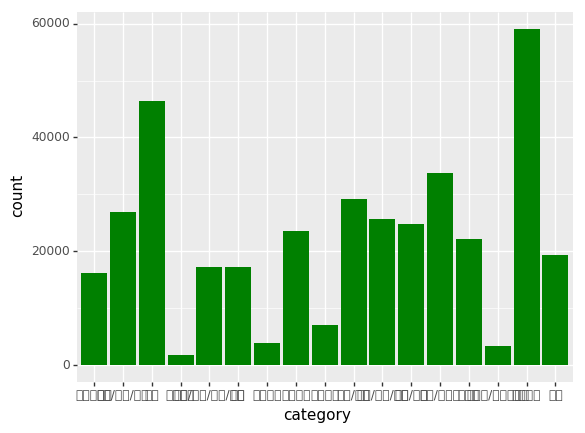

<ggplot: (-9223363253632918268)>

In [37]:
# 카테고리별로 집계된 데이터를 barplot으로 그려본다.
# 그런데 한글이 깨져보이는 것을 볼 수 있다.
(ggplot(petitions)
 + aes('category')
 + geom_bar(fill='green')
)

## 시각화를 위해 한글폰트 설치

In [38]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [0]:
# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

#### 한글폰트 사용하기
* 한글이 깨져보이는 것을 해결하기 위해 한글폰트를 사용해야 한다.
* 여기에서는 나눔바른고딕을 사용하도록 한다. 
    * 이때 폰트가 로컬 컴퓨터에 설치되어 있어야한다. 
    * 나눔고딕은 무료로 사용할 수 있는 폰트다. 
    * 참고 : [네이버 나눔글꼴 라이선스](https://help.naver.com/support/contents/contents.nhn?serviceNo=1074&categoryNo=3497)
* 한글을 사용하기 위해서는 ggplot에서 theme에 폰트를 지정해 주면된다.
* 아래의 문서를 참고하면 **element_text**와 관련된 옵션을 볼 수 있다.
* 참고 : [plotnine.themes.element_text — plotnine 0.3.0 documentation](http://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.element_text.html)

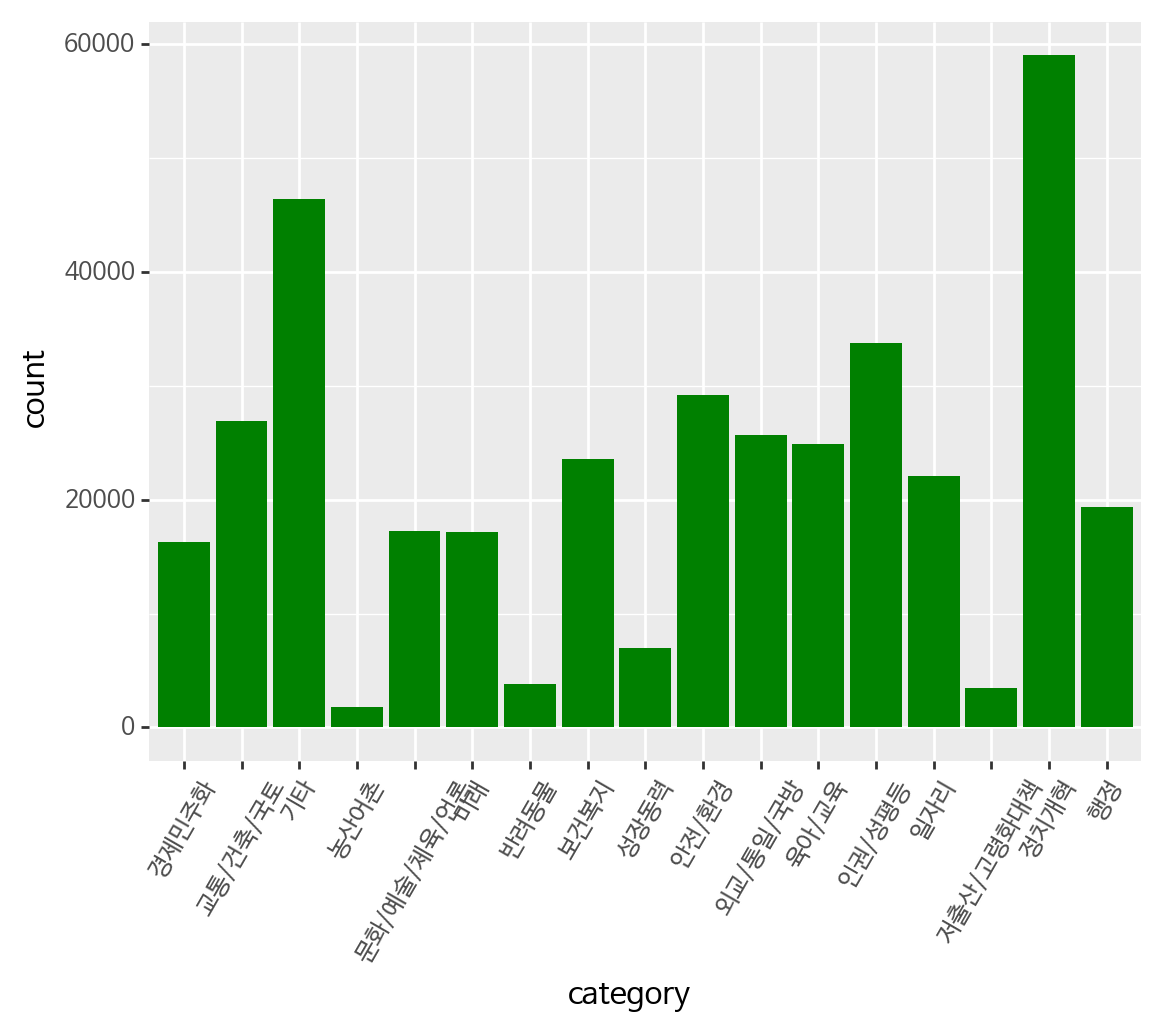

<ggplot: (8783219134535)>

In [40]:
# 글씨가 겹쳐보이지 않도록 rotation도 추가했다.
(ggplot(petitions)
 + aes('category')
 + geom_bar(fill='green')
 + theme(text=element_text(family='NanumBarunGothic'),
        axis_text_x=element_text(rotation=60))
)

### 카테고리별 투표수

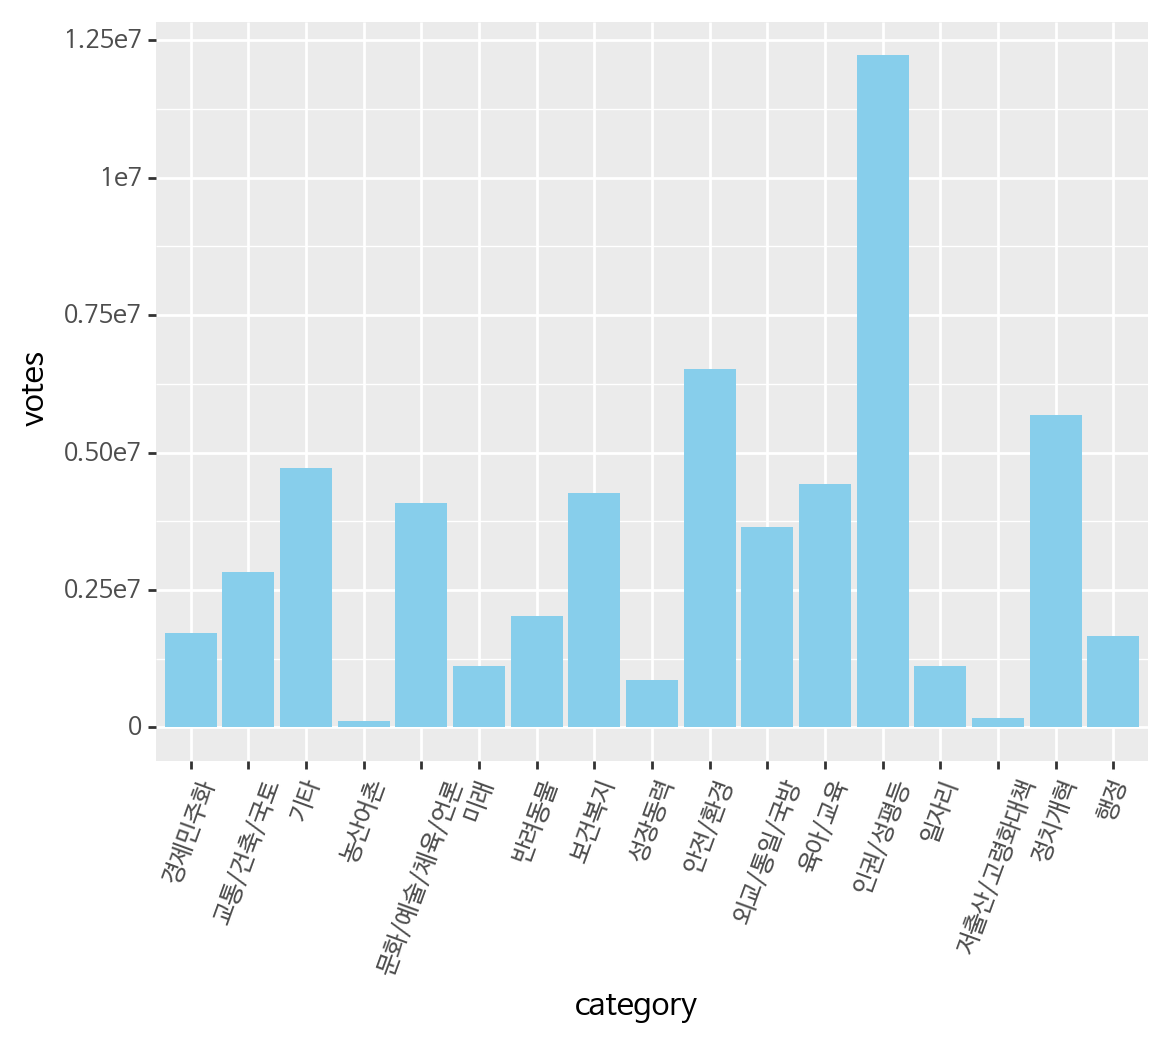

<ggplot: (8783219132564)>

In [41]:
# 다음으로 투표를 많이 받은 카테고리를 알아본다.
# 정치/개혁에 관련된 청원의 숫자가 가장 많았지만 투표를 가장 많이 받은 청원은 인권/성평등이다.
(ggplot(petitions)
 + aes(x='category', y='votes')
 + geom_col(fill='skyblue')
 + theme(text=element_text(family='NanumBarunGothic'),
        axis_text_x=element_text(rotation=70))
)

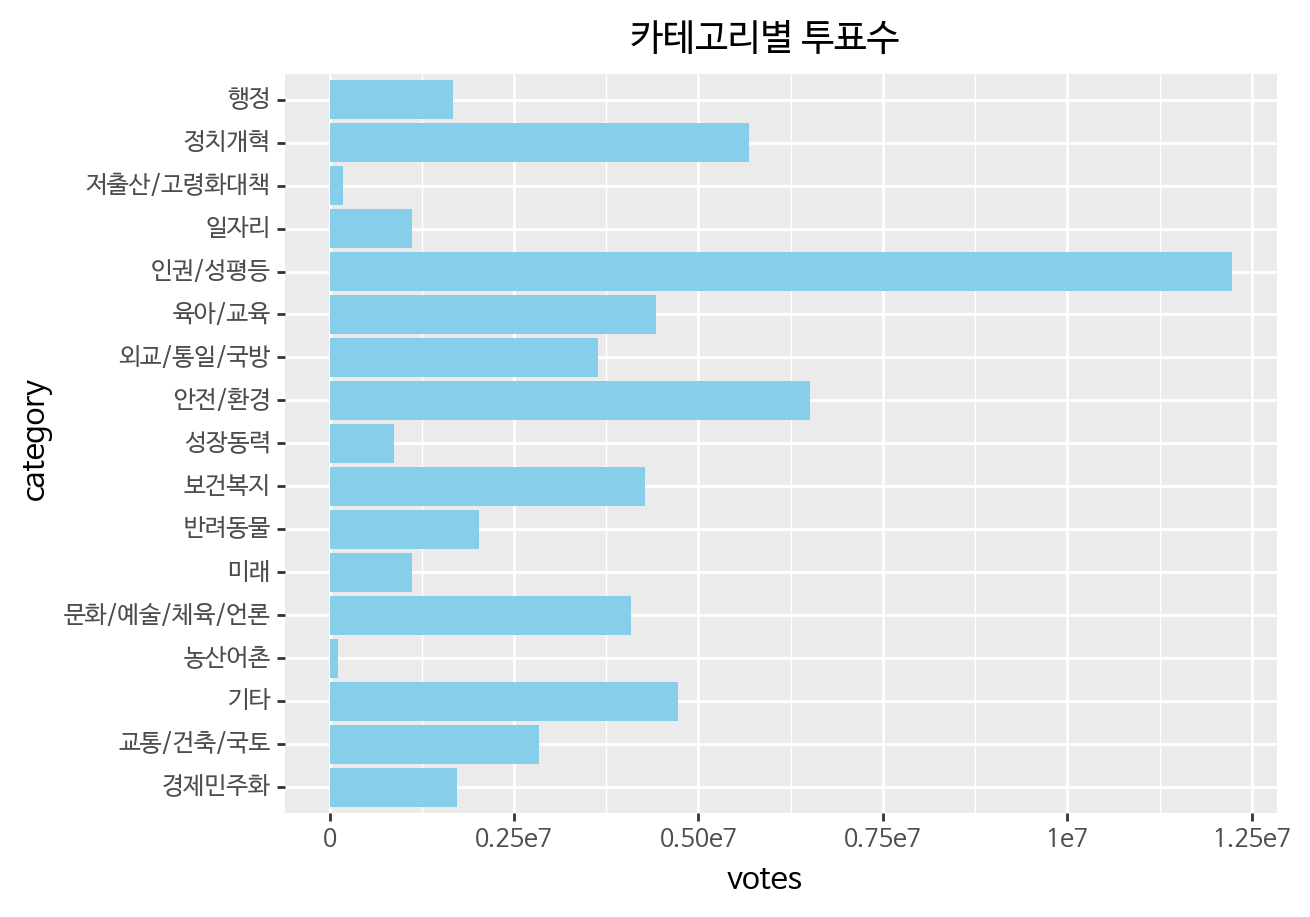

<ggplot: (-9223363253635663833)>

In [42]:
# coord_flip을 사용해서 x축과 y축을 바꿔본다.
(ggplot(petitions)
 + aes(x='category', y='votes')
 + geom_col(fill='skyblue')
 + ggtitle('카테고리별 투표수')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

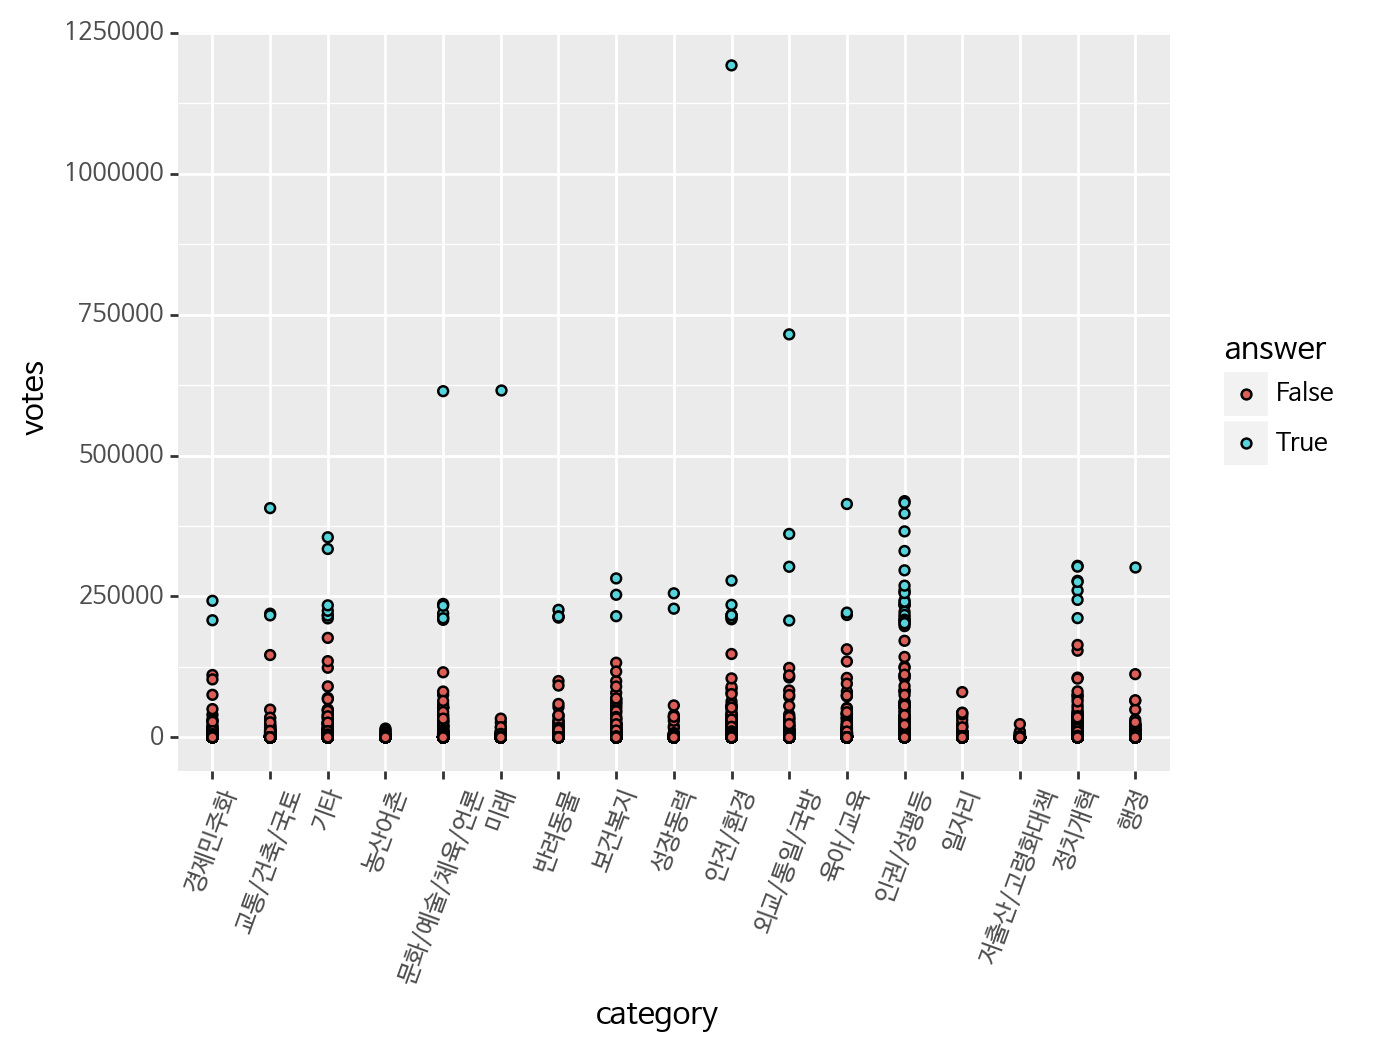

<ggplot: (-9223363253635633271)>

In [43]:
(ggplot(petitions) 
 + aes(x='category', y='votes', fill='answer')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'),
        axis_text_x=element_text(rotation=70))
)

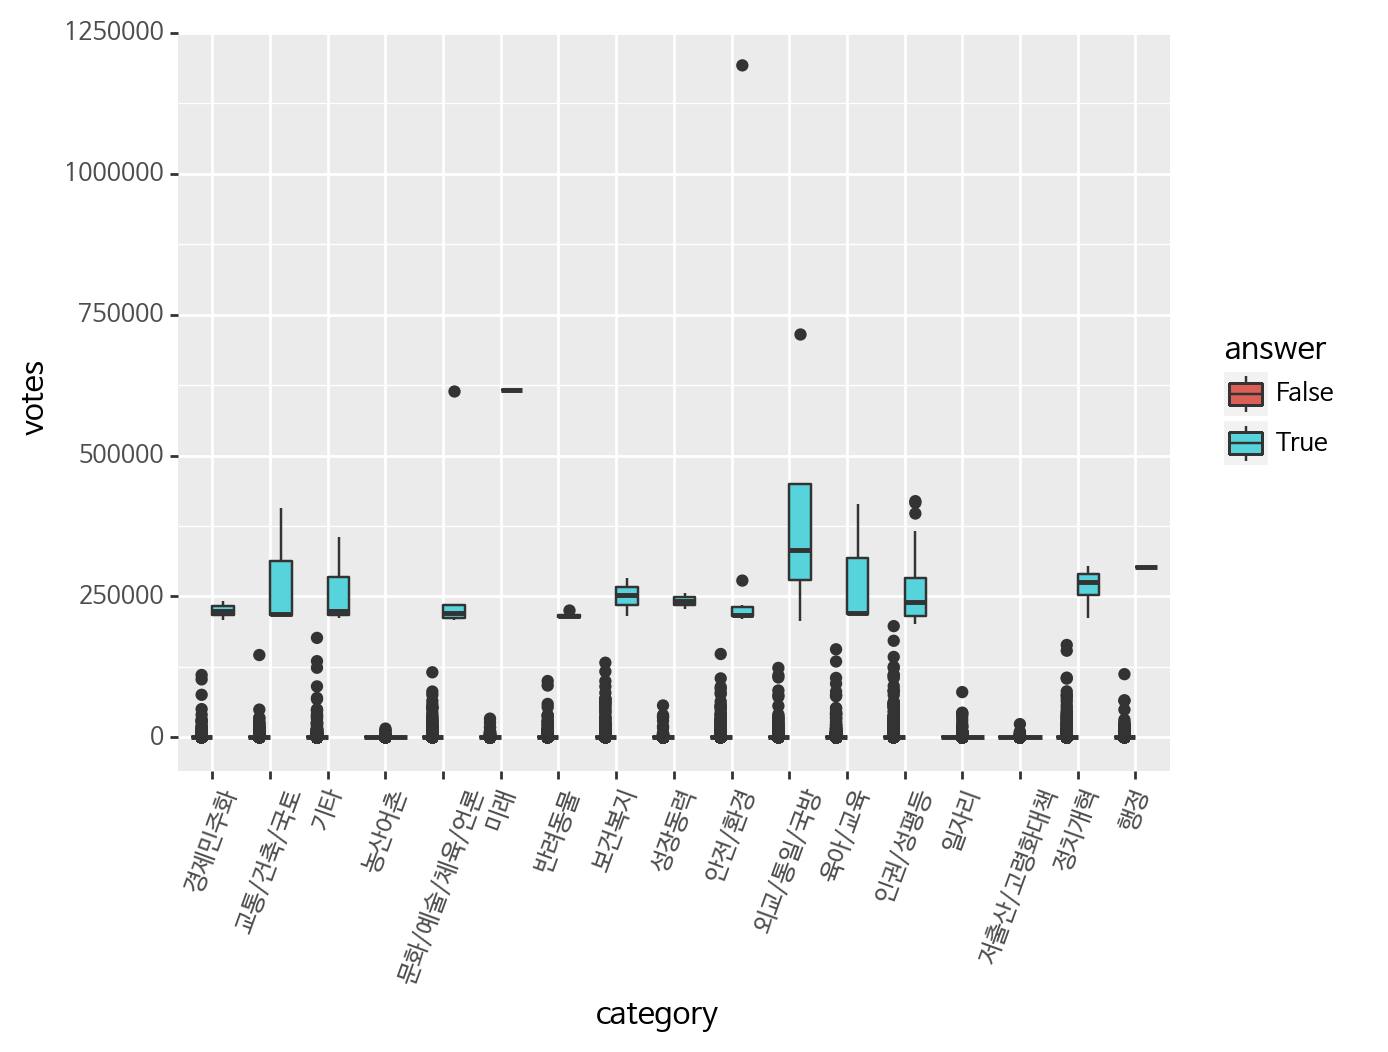

<ggplot: (8783216163497)>

In [44]:
(ggplot(petitions) 
 + aes(x='category', y='votes', fill='answer')
 + geom_boxplot()
 + theme(text=element_text(family='NanumBarunGothic'),
        axis_text_x=element_text(rotation=70))
)

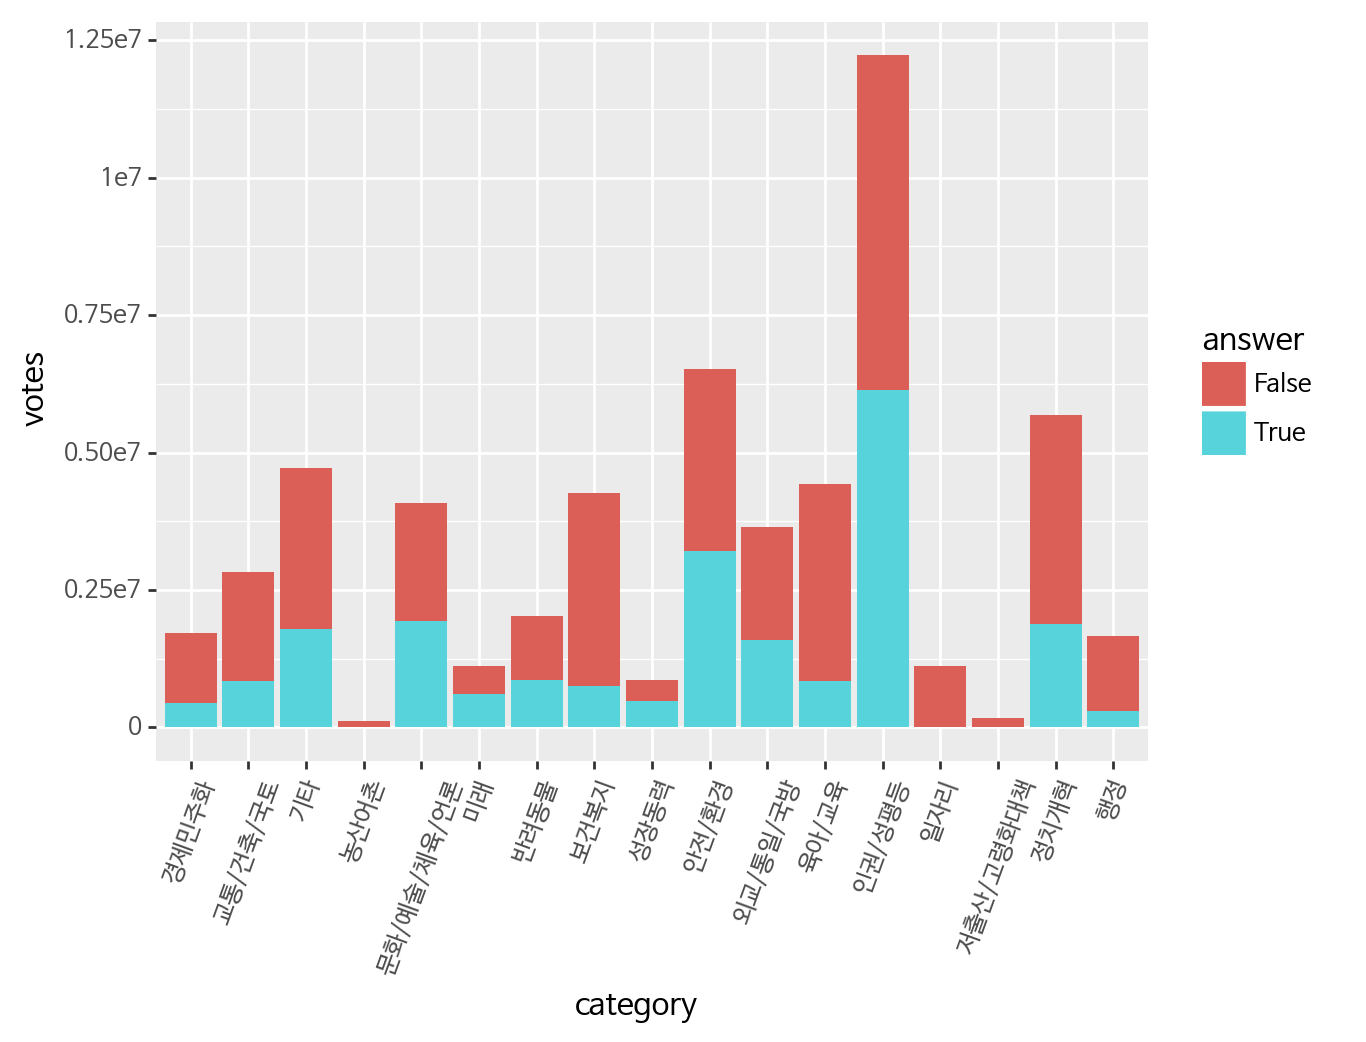

<ggplot: (8783214007879)>

In [45]:
(ggplot(petitions, aes(x='category', y='votes', fill='answer'))
 + geom_col()
 + theme(text=element_text(family='NanumBarunGothic'),
        axis_text_x=element_text(rotation=70))
)

In [46]:
# 투표를 가장 많이 받은 카테고리인 인권/성평등에서 투표수가 많은 순으로 상위 10개만 본다.
edu = petitions.loc[(petitions['category']=='인권/성평등')]
edu.sort_values('votes', ascending=False)[:10]

,start,end,answered,votes,category,title,content,answer,duration
article_id,,,,,,,,,
230552,2018-05-11,2018-06-10,1,419006,인권/성평등,여성도 대한민국 국민입니다. 성별 관계없는 국가의 보호를 요청합니다.,최근 홍대 누드크로키 모델의 불법촬영 사건이 있었습니다.\n사건은 굉장히 빠르게 처...,True,30 days
426834,2018-10-31,2018-11-30,0,416093,인권/성평등,"132cm, 31kg의 왜소한 50대 여성이 180cm가 넘는 건장한 20세 남성에...",http://m.news1.kr/articles/?3464603\n관련 기사입니다....,True,30 days
437737,2018-11-09,2018-12-09,0,397079,인권/성평등,억울하게 떠나신 저의 아버지의 원한을 풀어주세요,46일동안 눈 한번 뜨시지 못한 채 11월 6일 새벽 4시에 저의 아버지가 억울하게...,True,30 days
442093,2018-11-14,2018-12-14,0,365418,인권/성평등,이수역 폭행사건,11월 13일 새벽4시 경 이수역의 한 맥주집에서 남자 다섯명이 여성 두 명을 폭행...,True,30 days
369690,2018-09-06,2018-10-06,0,330587,인권/성평등,제 남편의 억울함을 풀어주세요!,제 남편이 어제 재판에서 징역6개월을 받고 그 자리에서 법정구속 되었습니다\n어제 ...,True,30 days
1785,2017-09-03,2017-11-02,1,296330,인권/성평등,청소년이란 이유로 보호법을 악용하는 잔인무도한 청소년들이 늘어나고있습니다. 반드시 ...,안녕하십니까. 청소년보호법이란 명목하에 나쁜짓을 일삼는 청소년들이 너무나 많아지고 ...,True,60 days
472309,2018-12-18,2019-01-17,0,269110,인권/성평등,조재범 코치를 강력처벌해주세요,그는 국가대표 심석희 외 다수의 여자선수들을 지속적으로 적어도 14년간 폭행해온 쓰...,True,30 days
412722,2018-10-20,2018-11-19,0,261418,인권/성평등,조두순의 출소를 반대합니다,제 얘기를 하기에 앞서 요즘 페이스북이라는 sns에서 화제가 되고 있는 글을 하나 ...,True,30 days
398030,2018-10-04,2018-11-03,0,257471,인권/성평등,성범죄피해자의 집주소와 주민번호등을 가해자에게 보내는 법원을 막아주세요,안녕하세요 저는 24살 95년생 여성입니다.\n2015년도에 준강간을 당해서 고소를...,True,30 days


## 시계열 데이터 보기

In [47]:
petitions['start_month'] = petitions['start'].dt.month
petitions['start_day'] = petitions['start'].dt.day
petitions['start_hour'] = petitions['start'].dt.hour
petitions.shape

(377756, 12)

In [48]:
petitions['start_month'].value_counts()

11    52847
9     40888
12    38498
1     37410
10    31687
8     28851
2     25857
7     25714
5     25499
6     25483
4     23227
3     21795
Name: start_month, dtype: int64

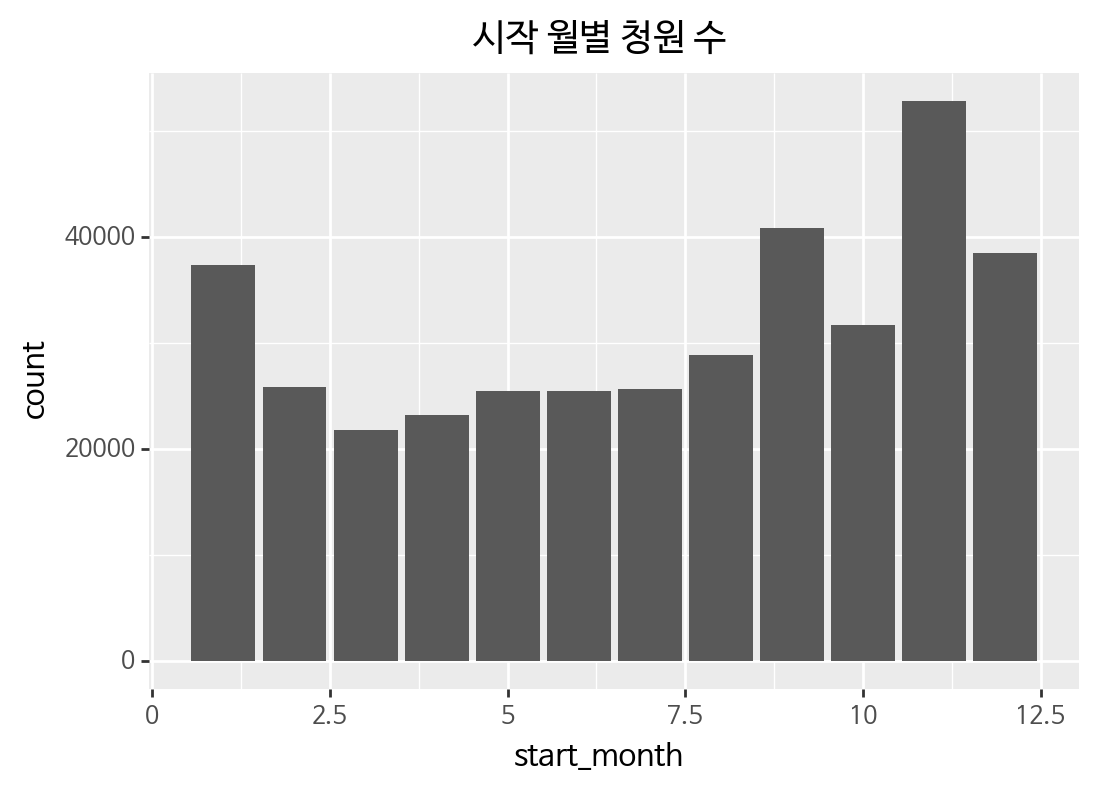

<ggplot: (-9223363253632942711)>

In [49]:
(ggplot(petitions)
 + aes('start_month')
 + geom_bar()
 + ggtitle('시작 월별 청원 수')
 + theme(text=element_text(family='NanumBarunGothic'),  figure_size=(6, 4))
)

In [50]:
start_day = petitions['start_day'].value_counts().reset_index()
start_day.columns = ['start', 'counts']
start_day = start_day.sort_values('start', ascending=True)
start_day[:3]

,start,counts
25,1,10887
23,2,11208
15,3,11798


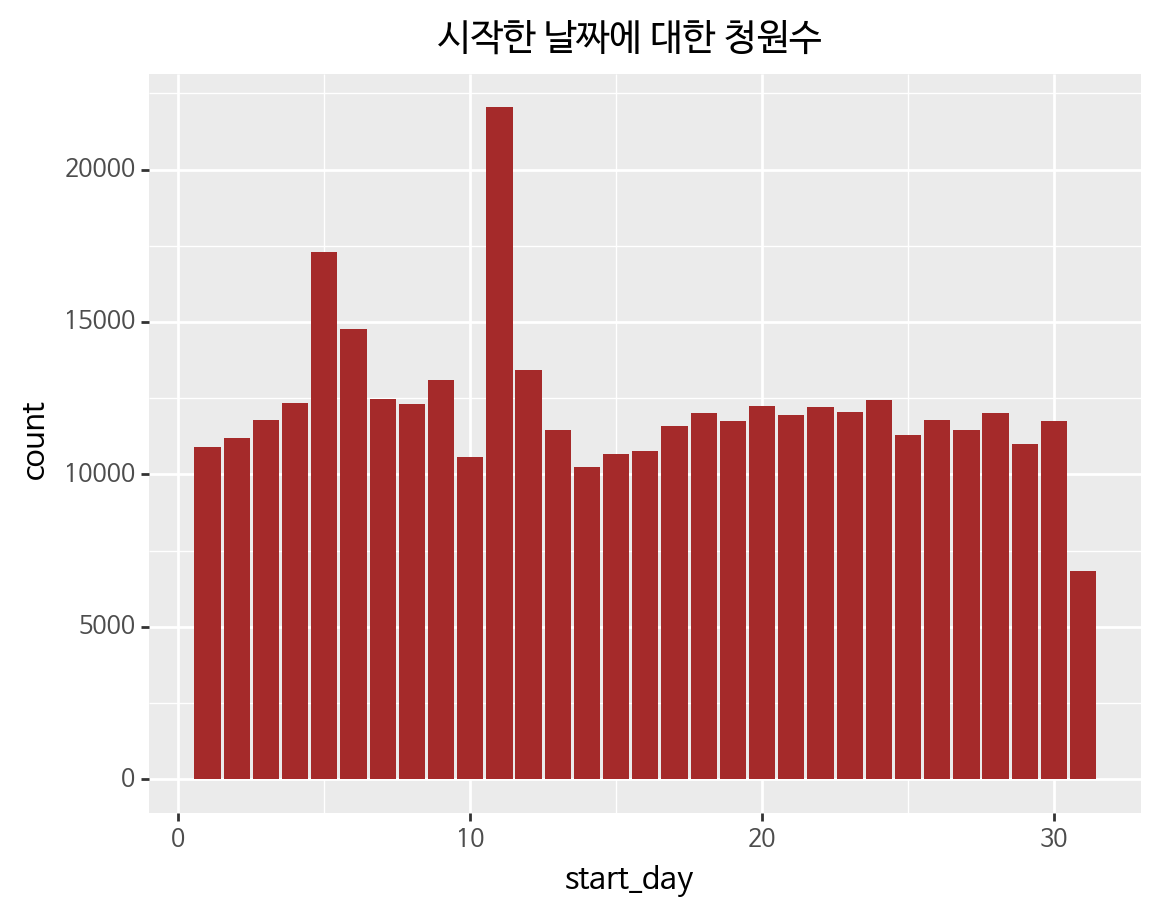

<ggplot: (-9223363253635680901)>

In [51]:
# 5일과 11일에 청원이 많이 등록되었다.
# 데이터를 보면 5일과 11일에 청원이 많이 등록된다기 보다는 
# 특정 시기에 5일과 11일에 같은 내용의 청원이 많이 들어 온 날이 있다.
# 따라서 날짜에 따라 규칙성을 찾기는 어렵다.
(ggplot(petitions)
 + aes('start_day')
 + geom_bar(fill='brown')
 + ggtitle('시작한 날짜에 대한 청원수')
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [52]:
# 날짜 데이터에 시간이 없기 때문에 시간은 의미가 없다.
petitions['start_hour'].value_counts()

0    377756
Name: start_hour, dtype: int64

In [53]:
# 날짜별 청원 수를 구하고 날짜로 정렬한다.
petition_count = petitions['start'].value_counts().reset_index()
petition_count.columns = ['start', 'count']
petition_count = petition_count['start'].sort_values().reset_index()
petition_count.columns = ['count', 'start']
petition_count.head()

,count,start
0,507,2017-08-19
1,500,2017-08-20
2,498,2017-08-21
3,505,2017-08-22
4,502,2017-08-23


In [54]:
start_df = pd.DataFrame(petitions['start'].value_counts()).reset_index()
start_df.columns = ['start', 'counts']
start_df = start_df.sort_values('start', ascending=True)
print('청원 집계: {}일'.format(start_df.shape[0]))
start_df.head()

청원 집계: 509일


,start,counts
507,2017-08-19,39
500,2017-08-20,88
498,2017-08-21,89
505,2017-08-22,69
502,2017-08-23,80


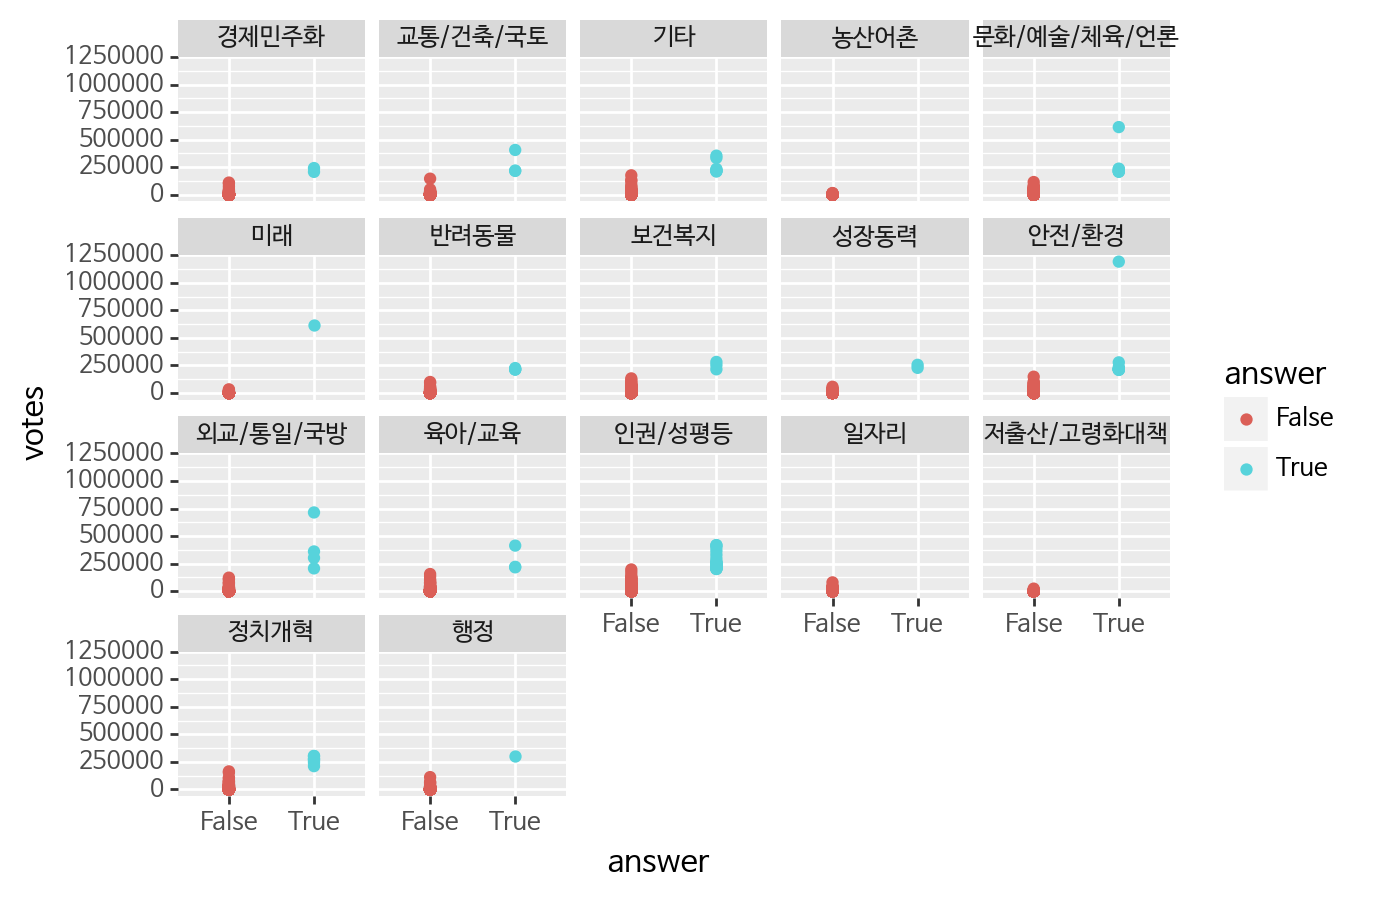

<ggplot: (8783219090219)>

In [55]:
# 날짜별로 카테고리별 투표수를 본다.
# 20만건 이상 투표를 받아야지만 답변을 받을 수 있다는것을 그래프를 통해 짐작해볼 수 있다.
# 답변을 받지못한 카테고리도 있다.
(ggplot(petitions)
 + aes('answer', 'votes')
 + aes(color='answer')
 + geom_point()
 + facet_wrap('~category')
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [56]:
start_ordered_df = petitions['start'].value_counts().index.tolist()
petitions_start_df = CategoricalDtype(categories=start_ordered_df, ordered=True)
petitions_start_df

CategoricalDtype(categories=['2017-11-11', '2017-09-05', '2018-01-11', '2018-02-06',
                  '2017-11-09', '2018-01-12', '2017-09-06', '2018-05-30',
                  '2018-01-17', '2018-02-20',
                  ...
                  '2017-08-28', '2017-08-20', '2017-08-25', '2017-08-23',
                  '2017-09-15', '2017-08-26', '2017-08-22', '2017-08-27',
                  '2017-08-19', '2017-09-16'],
                 ordered=True)

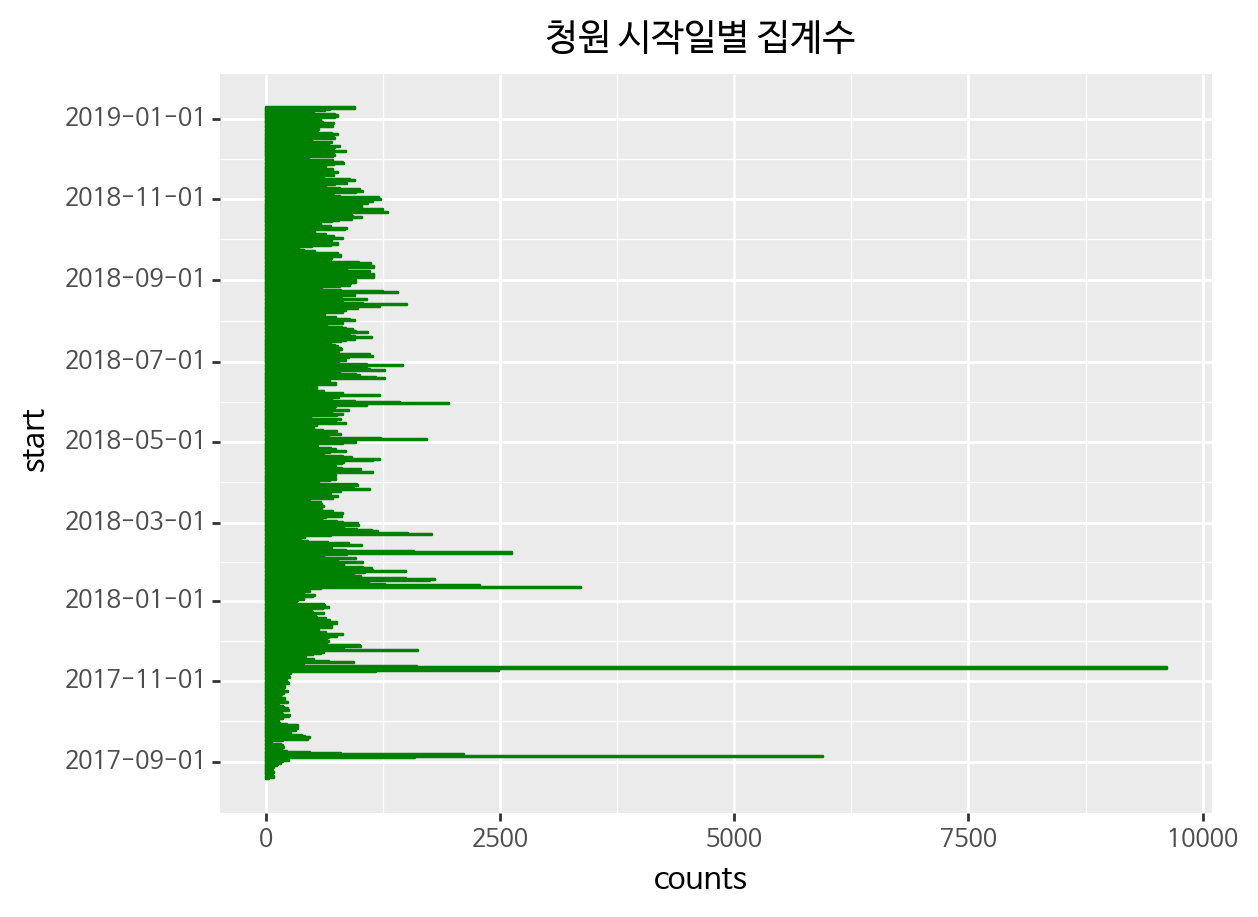

<ggplot: (8783212746504)>

In [57]:
# 특히 청원이 많은 날이 있다. 그날 무슨 이슈가 있었는지 궁금하다.
(ggplot(start_df)
 + aes('start', 'counts')
 + geom_col(color='green')
 + ggtitle('청원 시작일별 집계수')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

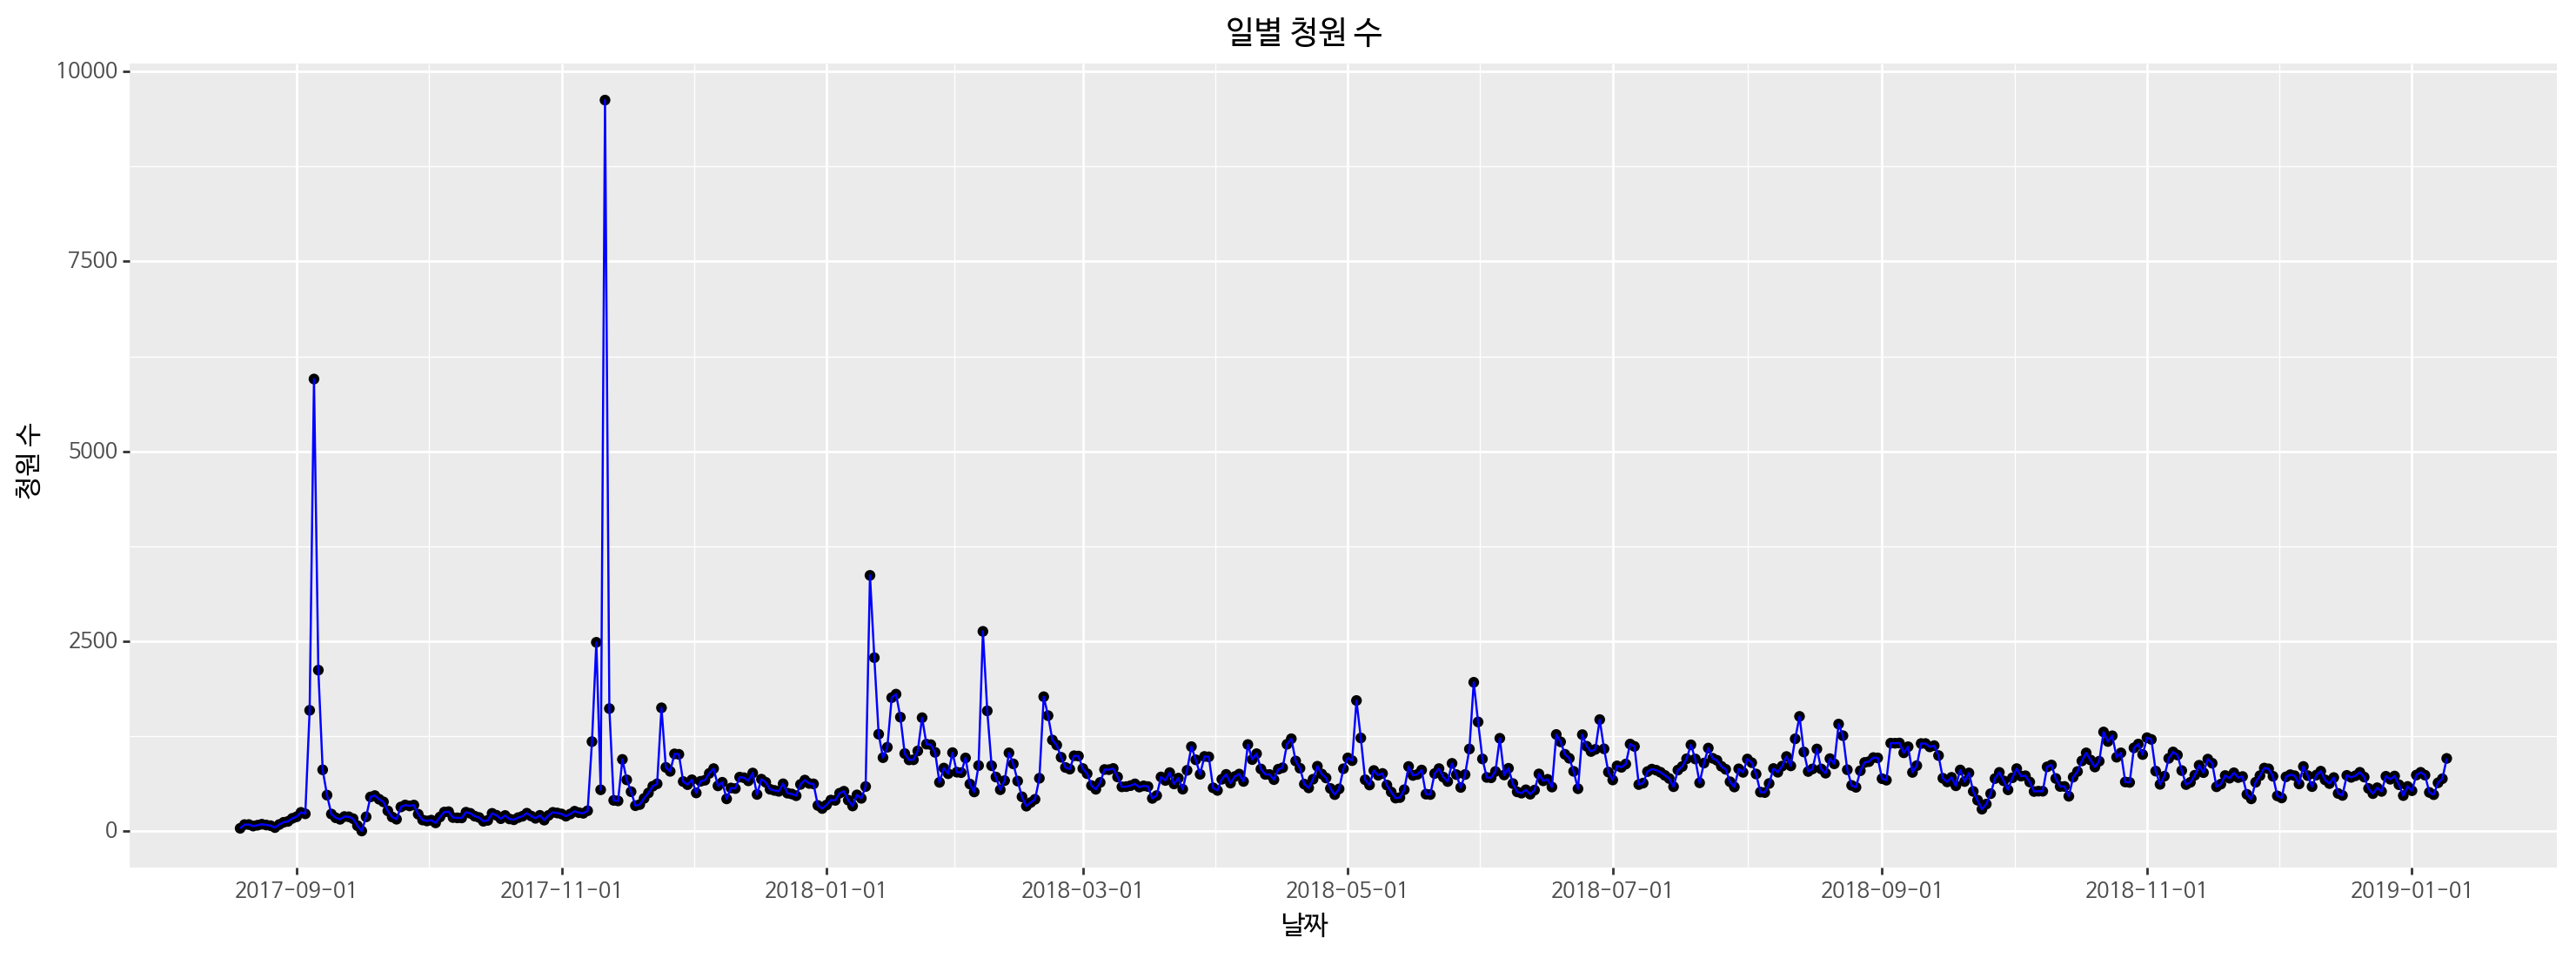

<ggplot: (8783215449152)>

In [58]:
(ggplot(start_df)
 + aes(x='start', y='counts')
 + geom_point()
 + geom_line(color='blue')
 + labs(x='날짜', y='청원 수', title='일별 청원 수')
 + theme(text=element_text(family='NanumBarunGothic'),
        figure_size=(18,6))
)

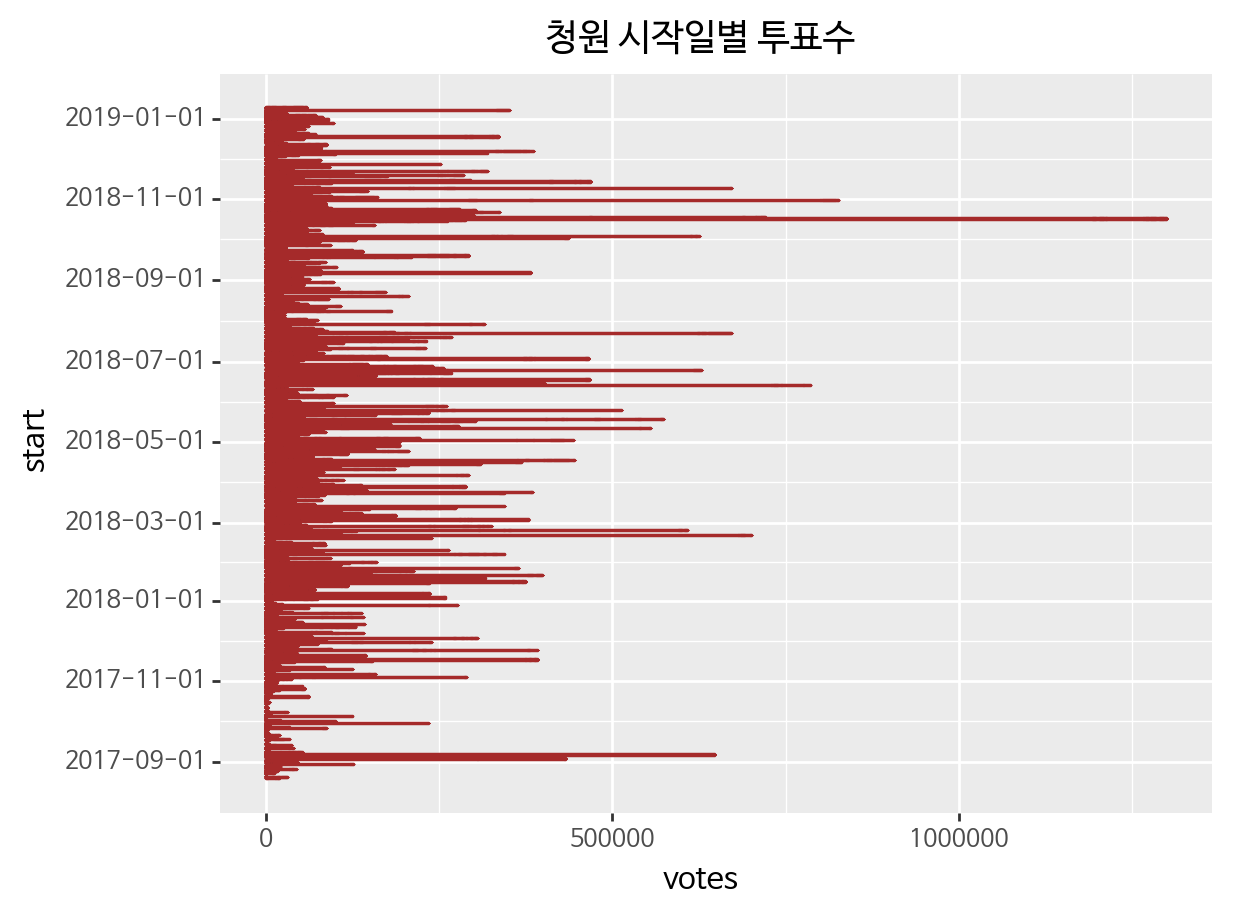

<ggplot: (-9223363253642242651)>

In [59]:
# 청원 시작 날짜별 투표수를 본다.
(ggplot(petitions)
 + aes('start', 'votes')
 + geom_col(color='brown')
 + ggtitle('청원 시작일별 투표수')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

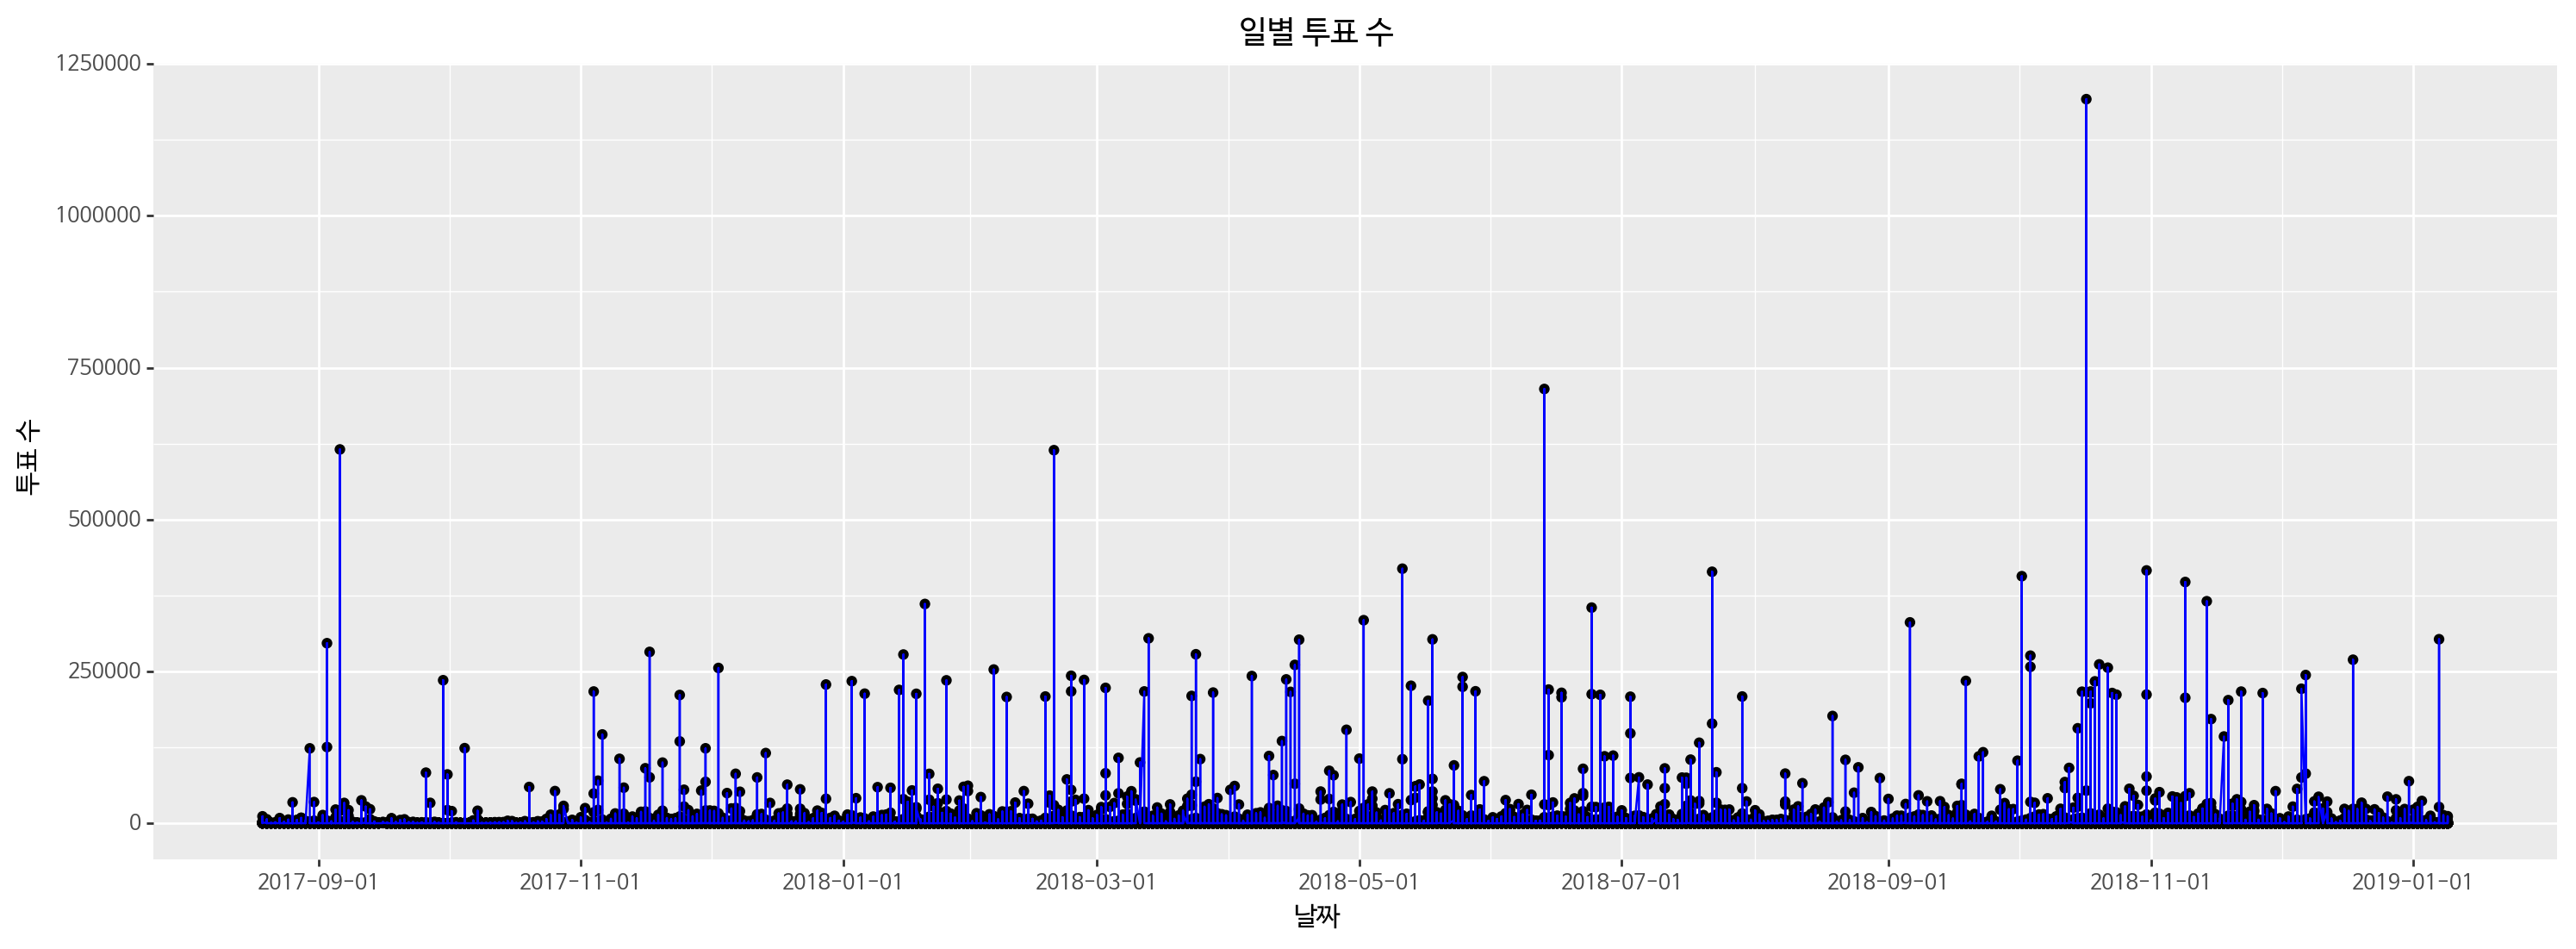

<ggplot: (-9223363253640855727)>

In [60]:
(ggplot(petitions)
 + aes(x='start', y='votes')
 + geom_point()
 + geom_line(color='blue')
 + labs(x='날짜', y='투표 수', title='일별 투표 수')
 + theme(text=element_text(family='NanumBarunGothic'),
        figure_size=(18,6))
)

In [61]:
# 데이터에서 청원시작일 최근 30일인 데이터만 보기
petition_count[-30:]

,count,start
479,177,2018-12-11
480,273,2018-12-12
481,307,2018-12-13
482,250,2018-12-14
483,388,2018-12-15
484,401,2018-12-16
485,224,2018-12-17
486,248,2018-12-18
487,231,2018-12-19
488,190,2018-12-20


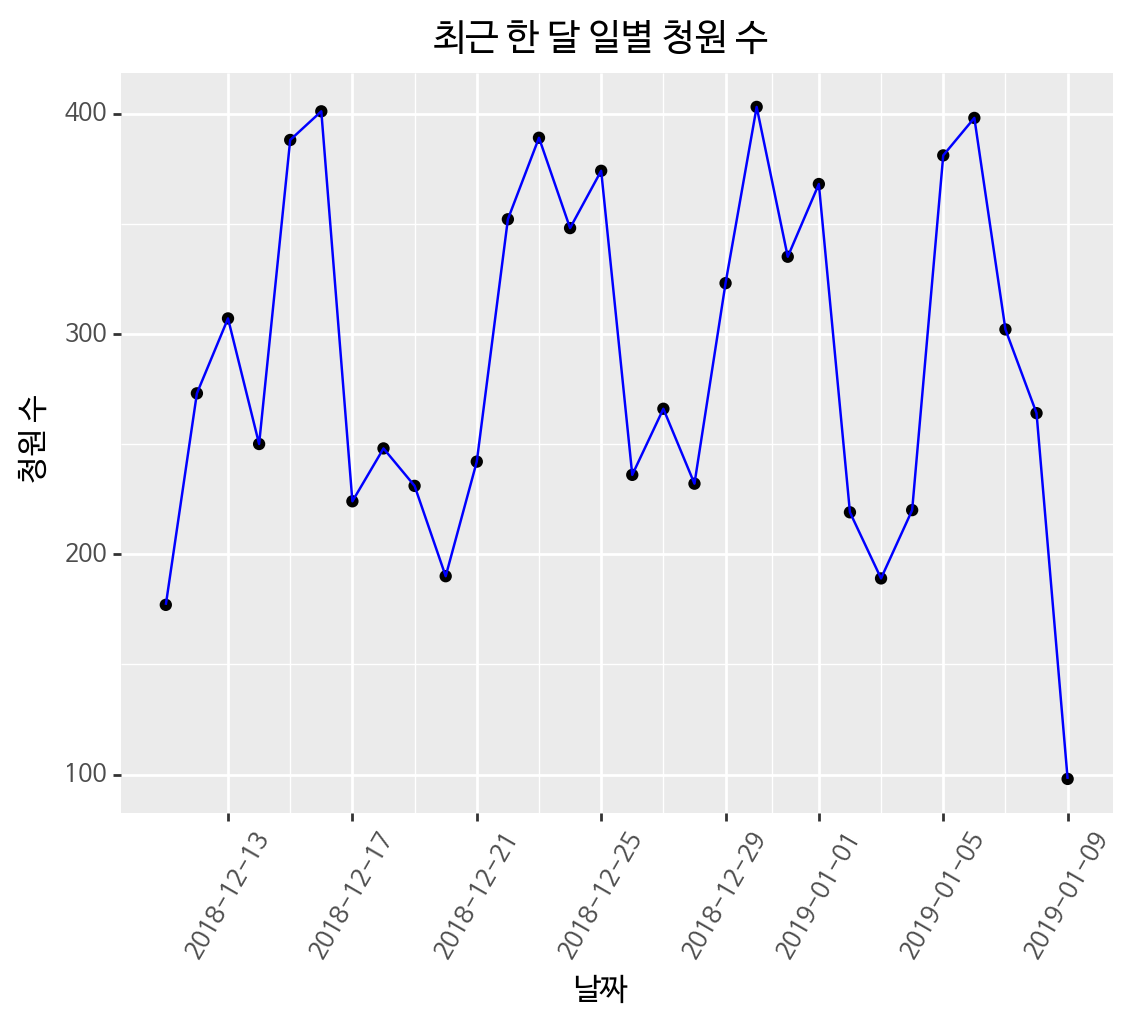

<ggplot: (8783226015005)>

In [62]:
(ggplot(petition_count[-30:])
 + aes(x='start', y='count')
 + geom_point()
 + geom_line(color='blue')
 + labs(x='날짜', y='청원 수', title='최근 한 달 일별 청원 수')
 + theme(text=element_text(family='NanumBarunGothic'),
        axis_text_x=element_text(rotation=60))
)

In [63]:
# 일별 투표수
petition_votes = petitions.groupby(['start'])['votes'].sum().reset_index()
petition_votes.columns = ['start', 'votes']
petition_votes.head()

,start,votes
0,2017-08-19,20703
1,2017-08-20,31710
2,2017-08-21,1884
3,2017-08-22,2607
4,2017-08-23,13446


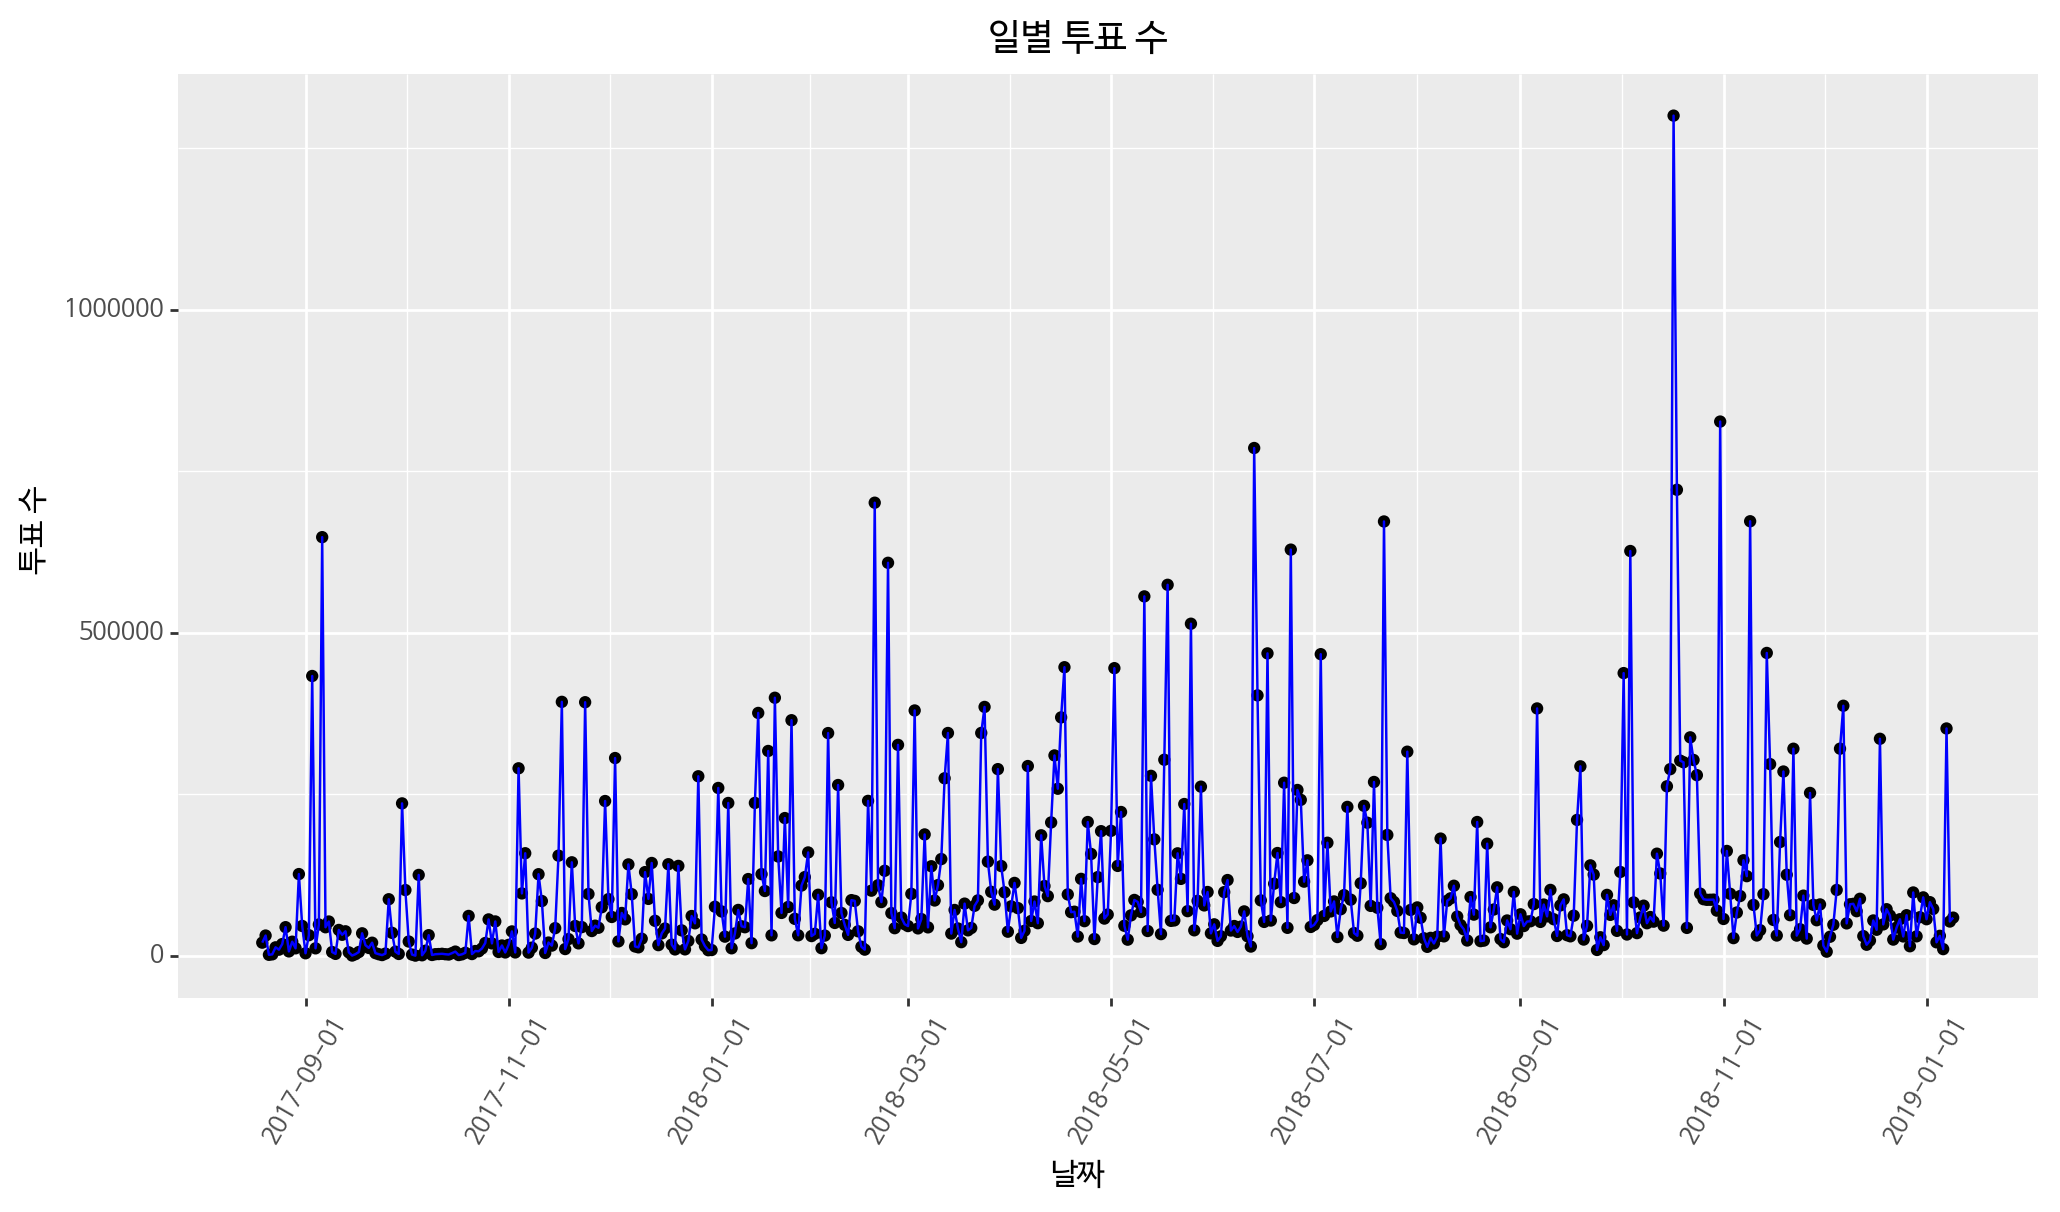

<ggplot: (-9223363253640860037)>

In [64]:
(ggplot(petition_votes)
 + aes(x='start', y='votes')
 + geom_point()
 + geom_line(color='blue')
 + labs(x='날짜', y='투표 수', title='일별 투표 수')
 + theme(text=element_text(family='NanumBarunGothic'),
        figure_size=(12,6),
        axis_text_x=element_text(rotation=60))
)

In [65]:
petition_votes[petition_votes['votes'] > 1000000]

,start,votes
424,2018-10-17,1300523


In [66]:
petitions[(petitions['start'] == '2018-10-17') &
          (petitions['votes'] > 1000000)]

,start,end,answered,votes,category,title,content,answer,duration,start_month,start_day,start_hour
article_id,,,,,,,,,,,,
408609,2018-10-17,2018-11-16,0,1192049,안전/환경,강서구 피시방 살인 사건. 또 심신미약 피의자입니다.,2018년 10월 14일 엊그제 일어난 강서구 피시방 살인사건에 대한 청원입니다.\...,True,30 days,10,17,0


## 청원이 많이 등록된 날
- 3천건 이상 청원이 등록된 날 어떤 청원이 있는지 본다.

In [67]:
# 청원이 3000 건이 넘는 날이 있다.
start_df.loc[start_df['counts'] > 3000]

,start,counts
1,2017-09-05,5952
0,2017-11-11,9623
2,2018-01-11,3368


In [68]:
petitions_20170905 = petitions.loc[petitions['start'] == '2017-09-05']
petitions_20170905.head()

,start,end,answered,votes,category,title,content,answer,duration,start_month,start_day,start_hour
article_id,,,,,,,,,,,,
3474,2017-09-05,2017-12-04,0,0,안전/환경,소년법 폐지 죄질은 나이가 없다,소년법 폐지 무서워서 애들을 키울수가 없어요,False,90 days,9,5,0
3475,2017-09-05,2017-12-04,0,0,인권/성평등,소년법폐지 제발 부탁드립니다,대통령님..부산여중생폭행사건 보셨는지요\n정말 아이를 키우고있는 부모로써 너무나 마...,False,90 days,9,5,0
3476,2017-09-05,2017-12-04,0,0,인권/성평등,청소년 보호법 폐지,청소년 보호법 폐지,False,90 days,9,5,0
3477,2017-09-05,2017-09-12,0,0,기타,청소년법 폐지해주세요,폐지해주세요 아이낳고 키우는게 이나라에선 너무 무섭습니다.,False,7 days,9,5,0
3478,2017-09-05,2017-09-12,0,0,기타,청소년법 폐지해주세요,폐지해주세요 아이낳고 키우는게 이나라에선 너무 무섭습니다.,False,7 days,9,5,0


In [69]:
petitions_20170905['category'].value_counts()

인권/성평등         2202
육아/교육          1105
안전/환경           880
기타              697
미래              436
정치개혁            319
행정              121
보건복지             41
외교/통일/국방         40
교통/건축/국토         25
일자리              25
성장동력             20
문화/예술/체육/언론      13
저출산/고령화대책        10
경제민주화             9
반려동물              7
농산어촌              2
Name: category, dtype: int64

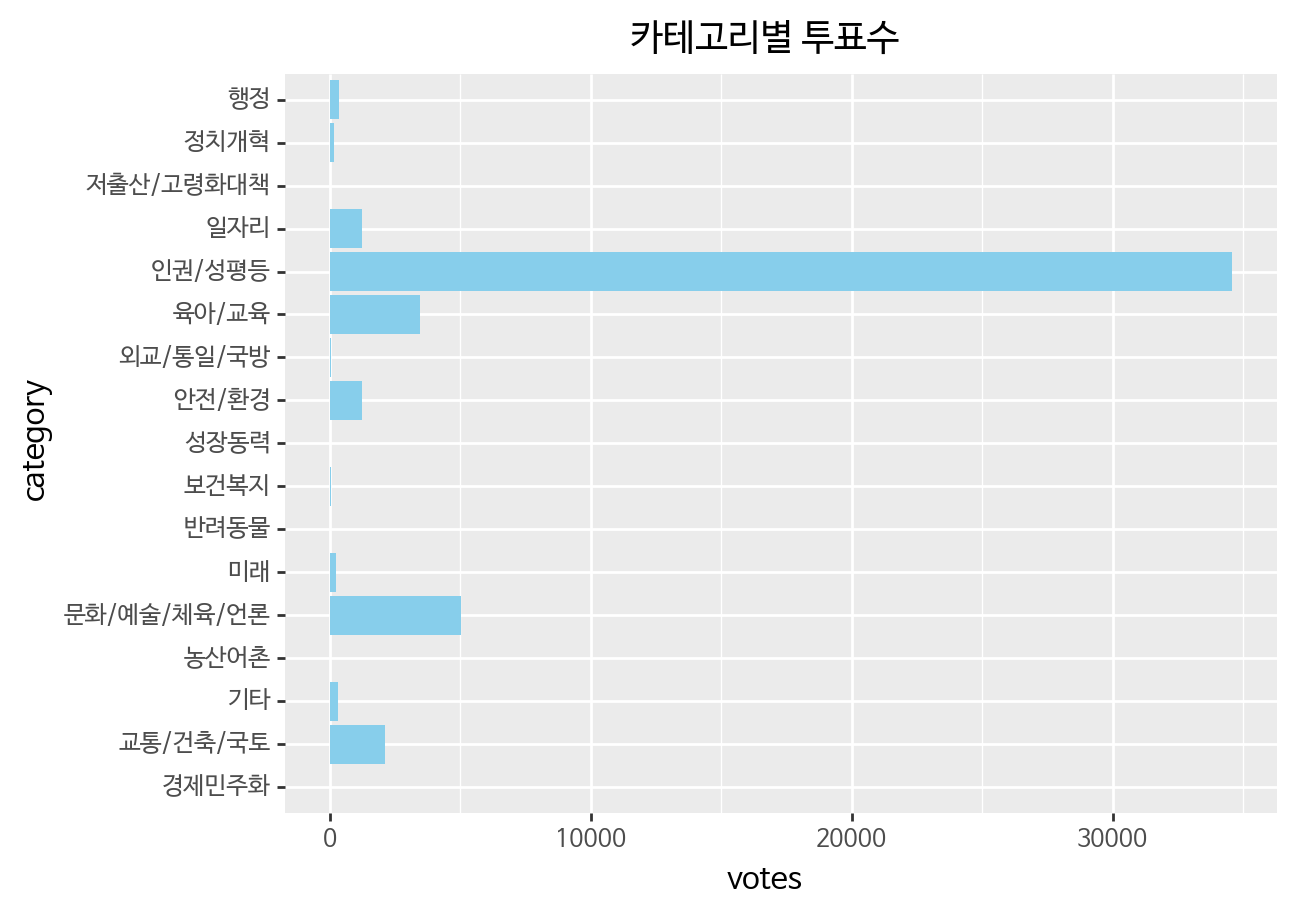

<ggplot: (8783214444471)>

In [70]:
(ggplot(petitions_20170905)
 + aes(x='category', y='votes')
 + geom_col(fill='skyblue')
 + ggtitle('카테고리별 투표수')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

## 정치개혁 분야의 청원이 많이 들어 온 날의 청원 내용보기
- 하지만 투표를 가장 많이 받은 청원은 보건/복지 분야의 청원이다.

In [71]:
petitions_20171111 = petitions.loc[petitions['start'] == '2017-11-11']
petitions_20171111.head()

,start,end,answered,votes,category,title,content,answer,duration,start_month,start_day,start_hour
article_id,,,,,,,,,,,,
31383,2017-11-11,2017-12-11,0,1,정치개혁,이명박 출국금지,이명박 출국금지\n조속한 구속수사,False,30 days,11,11,0
31384,2017-11-11,2017-12-11,0,3,인권/성평등,조두순 출소 금지,조두순의 출소금지 특별법 제정을 촉구 합니다.,False,30 days,11,11,0
31386,2017-11-11,2017-12-11,0,39,정치개혁,이명박 출국금지,정의가 바로 선 나라를 만들기 위해 꼭...!,False,30 days,11,11,0
31387,2017-11-11,2017-12-11,0,2,정치개혁,이명박출국금지시켜라,명박이을출국금지시키고 수사하라,False,30 days,11,11,0
31388,2017-11-11,2017-12-11,0,1,정치개혁,이명박출국금지시켜라,명박이을출국금지시키고 수사하라,False,30 days,11,11,0


In [72]:
petitions_20171111['category'].value_counts()

정치개혁           7961
기타              865
미래              170
인권/성평등          154
안전/환경           128
외교/통일/국방         61
행정               59
경제민주화            47
육아/교육            46
일자리              25
반려동물             24
보건복지             20
문화/예술/체육/언론      19
교통/건축/국토         16
성장동력             15
저출산/고령화대책         7
농산어촌              6
Name: category, dtype: int64

## Groupby 메서드 사용하기

https://pandas.pydata.org/pandas-docs/stable/api.html#groupby

In [73]:
petitions_20171111.groupby(['category'])['votes'].sum()

category
경제민주화             25
교통/건축/국토         976
기타               461
농산어촌               6
문화/예술/체육/언론     1378
미래               132
반려동물              22
보건복지           58498
성장동력               4
안전/환경             78
외교/통일/국방        1924
육아/교육             98
인권/성평등         16338
일자리               20
저출산/고령화대책         10
정치개혁            5080
행정                24
Name: votes, dtype: int64

## pivot_table 사용하기

In [74]:
# 각 데이터의 수를 집계했다. 2017년 11월 11일에 가장 많은 청원이 들어 온 것은 정치개혁이다.
# values에 지정해 준 start_month는 데이터의 갯수를 세는 목적으로 사용했다.
petitions_unique = pd.pivot_table(petitions_20171111, 
                                  index=['category'], 
                                  values=['start_month', 'votes'], 
                                  aggfunc=np.sum)
petitions_best = petitions_unique.sort_values(by='votes', ascending=False)
petitions_best

,start_month,votes
category,,
보건복지,220,58498
인권/성평등,1694,16338
정치개혁,87571,5080
외교/통일/국방,671,1924
문화/예술/체육/언론,209,1378
교통/건축/국토,176,976
기타,9515,461
미래,1870,132
육아/교육,506,98


## 제목과 내용의 길이
### 제목과 내용에 들어가는 단어수

In [75]:
# 단어 수
%time petitions['title_num_words'] = petitions['title'].apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
%time petitions['title_num_uniq_words'] = petitions['title'].apply(lambda x: len(set(str(x).split())))

CPU times: user 350 ms, sys: 5.96 ms, total: 356 ms
Wall time: 362 ms
CPU times: user 601 ms, sys: 0 ns, total: 601 ms
Wall time: 606 ms


In [0]:
# 단어 수
%time petitions['content_num_words'] = petitions['content'].apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
%time petitions['content_num_uniq_words'] = petitions['content'].apply(lambda x: len(set(str(x).split())))

CPU times: user 2.88 s, sys: 1.67 ms, total: 2.88 s
Wall time: 2.88 s


In [0]:
petitions.head()

In [0]:
(ggplot(petitions)
 + aes('title_num_words', 'content_num_words')
 + geom_point(fill='red', color='lightgray', alpha=0.25)
 + ggtitle('제목, 내용 단어 수')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [0]:
(ggplot(petitions)
 + aes('votes', 'content_num_words')
 + geom_jitter(fill='red', color='lightgray', alpha=0.25)
 + ggtitle('투표수와 내용 단어 수')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
 + scale_fill_gradient(low = 'red', high = 'yellow') 
)

## 특정 단어가 들어가는 청원보기

In [0]:
crypto = petitions[( petitions.title.str.find('가상화폐') != -1 ) | ( petitions.content.str.find('가상화폐') != -1  )]
crypto.shape

In [0]:
import re
p = r'.*(돌봄|아이|초등|보육).*'
care = petitions[petitions['title'].str.match(p) |
           petitions['content'].str.match(p, flags=re.MULTILINE)]
care.shape